#**Computer Vision : Assignment 2 - CAPTCHA Solver**
**Group :** \
Duarte Ribeiro Afonso Branco (up201905327@up.pt) \
Manuel de Magalhães Carvalho Cerqueira da Silva (up201806391@up.pt)

**Note** If for some reason there is any problem running the Colab, please contact us.

# **Introduction**

The goal of this project is the development of a pipeline to solve a CAPTCHA image with 4 or 5 encoders. The developed pipeline consists of two steps:

Pre-Processing: Used to remove noise, segment and resize the CAPTCHA into images with only one digit.

CNN: Used to determine the digit in the pre-process images.


#**Download Datasets:**

In [ ]:
!pip install gdown
!pip install patool
import patoolib

!gdown --folder https://drive.google.com/drive/folders/1BUBdSbh8MS3TfmP8JsbNztZVp-7F8AEm?usp=sharing
patoolib.extract_archive("a2/CAPTCHA_dataset.rar", outdir=".")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.7/93.7 kB 1.9 MB/s eta 0:00:00
Retrieving folder list
Processing file 11rY0IyM7lfumqe0vjBIVvvm1-g5W7in3 CAPTCHA_dataset.rar
Retrieving folder list completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=11rY0IyM7lfumqe0vjBIVvvm1-g5W7in3
To: /content/a2/CAPTCHA_dataset.rar
100% 116M/116M [00:02<00:00, 52.4MB/s]
Download completed


INFO patool: Extracting a2/CAPTCHA_dataset.rar ...
INFO:patool:Extracting a2/CAPTCHA_dataset.rar ...
INFO patool: running /usr/bin/unrar x -- /content/a2/CAPTCHA_dataset.rar
INFO:patool:running /usr/bin/unrar x -- /content/a2/CAPTCHA_dataset.rar
INFO patool:     with cwd='.', input=''
INFO:patool:    with cwd='.', input=''
INFO patool: ... a2/CAPTCHA_dataset.rar extracted to `.'.
INFO:patool:... a2/CAPTCHA_dataset.rar extracted to `.'.


'.'

# **Set Nvidia GPU**

In [ ]:
!nvidia-smi

Wed Dec 13 22:43:06 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# **Imports**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import random
from collections import Counter

import os
import cv2

from collections import defaultdict

from torch import nn
import torch
import torch.utils.data as data
from torch.utils.data import Dataset, WeightedRandomSampler, DataLoader
from torch.autograd import Variable
import torch.nn.functional as F
from torch.optim import SGD, Adam

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score

import gc


# **Global Auxiliary Functions**

In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


def plotMultipleImages(images, titles=None, plot=False):

    if (plot == False):
        return

    num_images = len(images)

    plt.close('all')
    fig, axes = plt.subplots(1, num_images, figsize=(4 * num_images, 4))

    if num_images == 1:
        axes.imshow(cv2.cvtColor(images[0], cv2.COLOR_BGR2RGB))
        if titles:
            axes.set_title(titles[0])
        axes.set_xlabel("X (pixels)")
        axes.set_ylabel("Y (pixels)")
    else:
        for i in range(num_images):
            axes[i].imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
            if titles:
                axes[i].set_title(titles[i])
            axes[i].set_xlabel("X (pixels)")
            axes[i].set_ylabel("Y (pixels)")

    plt.tight_layout()
    plt.show()

def plot_histogram(labels, nrows, ncols, index, title='Histogram title', bars_color='blue'):
    num_classes = 36

    class_names = [chr(i) for i in range(ord('a'), ord('z') + 1)] + [str(i) for i in range(10)]

    plt.subplot(nrows, ncols, index)
    plt.title(title)
    plt.hist(labels, bins=np.arange(num_classes + 1) - 0.5, alpha=0.7, color=bars_color, label='True', rwidth=0.8)
    plt.xticks(range(num_classes))
    plt.gca().set_xticklabels(class_names)

def calculate_digit_accuracy(y_true, y_pred):
    num_classes = 36

    # Initialize counters for correct predictions and total occurrences
    correct_predictions = [0] * num_classes
    total_occurrences = [0] * num_classes

    for true_label, pred_label in zip(y_true, y_pred):
        total_occurrences[true_label] += 1
        if true_label == pred_label:
            correct_predictions[true_label] += 1

    # Calculate digit accuracy for each class
    digit_accuracy = [correct / total if total > 0 else 0 for correct, total in zip(correct_predictions, total_occurrences)]

    # Calculate overall accuracy
    overall_accuracy = sum(correct_predictions) / sum(total_occurrences) if sum(total_occurrences) > 0 else 0

    return digit_accuracy, overall_accuracy

def visualize_results(y_true, y_pred):
    plt.figure(figsize=(15, 10))
    num_classes = 36

    # plot_histogram(y_true, 2, 2, 1, title='True labels', bars_color='blue')
    # plot_histogram(y_pred, 2, 2, 2, title='Predicted Labels', bars_color='green')

    # plt.tight_layout()
    # plt.show()

    digit_accuracy, overall_accuracy = calculate_digit_accuracy(y_true, y_pred)

    accuracy_by_class = list(zip(digit_accuracy, [chr(i) for i in range(ord('a'), ord('z') + 1)] + [str(i) for i in range(10)]))
    accuracy_by_class.sort(key=lambda x: x[0])  # Sort by class label

    ordered_accuracies, class_labels = zip(*accuracy_by_class)

    print("Digit Accuracy by Class:")
    # for label, acc in zip(class_labels, ordered_accuracies):
    #      print(f"Class {label}: {acc:.4f}")

    plt.figure(figsize=(8, 4))
    plt.bar(class_labels, ordered_accuracies, color='skyblue')
    plt.xlabel('Class Labels')
    plt.ylabel('Accuracy')
    plt.title('Accuracies by Class')
    plt.tight_layout()

    plt.show()
    print("The overall testing accuracy is " + str(overall_accuracy))

    return overall_accuracy


def plot_training_performance(train_loss, train_accuracy, val_loss=None, val_accuracy=None):
    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(12, 5))

    # Plotting Training Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='Training Loss', marker='o')
    if val_loss is not None:
        plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
        plt.title('Training and Validation Loss')
        plt.legend()
    else:
        plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    # Plotting Training Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracy, label='Training Accuracy', marker='o')
    if val_accuracy is not None:
        plt.plot(epochs, val_accuracy, label='Validation Accuracy', marker='o')
        plt.title('Training and Validation Accuracy')
        plt.legend()
    else:
        plt.title('Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(labels, pred_labels):
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(1, 1, 1)

    class_names = [chr(i) for i in range(ord('a'), ord('z') + 1)] + [str(i) for i in range(10)]

    cm = confusion_matrix(labels, pred_labels)
    cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    cm.plot(values_format='d', cmap='Blues', ax=ax)

def classification_to_digit(classification):
    if 0 <= classification < 26:
        digit = chr(classification + ord('a'))
    elif 26 <= classification < 36:
        digit = chr(classification - 26 + ord('0'))
    else:
        digit = None
    return digit

# **Pre-Processing**

The Pre-Processing algorithm was developed in order to convert the raw captcha images, with noise and multiple digits, into binary, fixed dimension, single digit images that can be analysed by the CNN.

Firstly, the raw captcha images are grayscaled and thresholded into a binary image.

Next, an open morphological operation is done in order to remove most of the noise, namely, the dots and the lines.

The resulting image is then dilated a lot using a rectangular kernel, in a way that ecloses the whole digit, including the dots of dotted letters (i and j), and used as a mask which is applied to the original binary image. In this way it's possible to obtain an image with the digits and no noise, not affected by the adverse effects of the open operation on the digits' shape.

Then the connected component contours are determined and filtered using minimal area.

The contours are then used as a mask applied to the original binary image in order to extract the single digit images. In the case of dotted letters, the dots and body of the letter will be in different contours, so if multiple contours overlap in the x-axis, the contours are stored in a list and combined into the mask.

Finally, the single digits images are resized into a 100x100 image that can be used by the CNN. This step is done in a way that keeps the digit's aspect ratio. If the digit's aspect ratio indicates too wide a letter, this means that the single digit may in fact be two digits very close together. Consequently, the image is broken in half and both are then resized.

In [ ]:
def filterLettersContours(binaryImage, markers, minContourArea=70):

    filteredContours = []

    for marker in np.unique(markers):
        # Skip background
        if marker == 0:
            continue

        markerMask = np.zeros_like(binaryImage, dtype=np.uint8)
        markerMask[markers == marker] = 255

        # Detect countour of current marker only
        contours, hierarchy = cv2.findContours(markerMask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        for contour in contours:
            contourArea = cv2.contourArea(contour)
            if contourArea > minContourArea:
                filteredContours.append(contour)


    return filteredContours

def extractLettersOnlyImage(binaryImage, lettersContours, plot=False):

    mask = np.zeros_like(binaryImage)
    # Draw the contours on the mask and fill them in (cv2.FILLED)
    cv2.drawContours(mask, lettersContours, -1, 255, thickness=cv2.FILLED)
    lettersOnlyImage = cv2.bitwise_and(binaryImage, mask)

    plotMultipleImages([binaryImage, lettersOnlyImage], ["Binary Image", "Letters Only Image"], plot)

    return lettersOnlyImage

def resize_Image(images, resizeImageSize):

    resizedImages = []

    for image in images:

        height, width = image.shape
        aspectRatio = width / height

        # Resize letter to half the resize Image Size, while keeping the aspect ratio
        if aspectRatio < 1:  # Image is taller than widder, so widht will be smaller
            resizeLetterWidth = int(aspectRatio * (resizeImageSize / 2))
            resizeLetterHeight = int(resizeImageSize / 2)
        # Image is widder than taller, so height should be smaller (1/aspectRatio < 1)
        else:
            resizeLetterWidth = int(resizeImageSize / 2)
            resizeLetterHeight = int((1 / aspectRatio) * (resizeImageSize / 2))

        letterImageResized = cv2.resize(
            image, (resizeLetterWidth, resizeLetterHeight), interpolation=cv2.INTER_CUBIC)

        # Offset to center letter
        offsetX = int((resizeImageSize - resizeLetterWidth) / 2)
        offsetY = int((resizeImageSize - resizeLetterHeight) / 2)

        # Insert resized letter
        resizedImage = np.zeros(
            (resizeImageSize, resizeImageSize), dtype=np.uint8)

        resizedImage[offsetY:offsetY+resizeLetterHeight, offsetX:offsetX+resizeLetterWidth] = letterImageResized

        resizedImages.append(resizedImage)

    return resizedImages

def separateLetters_Resized_SortedLeftToRight(binaryImage, lettersContour, resizeImageSize=100, plot=False, sameLetterContourXTresh = 0, twoLettersAspectRatioTresh = 0.65):

    separatedLetters = []

    # Sort lettersContours from left to right using the x position of the bounding rectangle
    sortedLettersContours = sorted(
        lettersContour, key=lambda c: cv2.boundingRect(c)[0])

    alreadyCombinedIndexs = []


    # Group contours if contour2 inside x range of contour1, since i and j have separate contours
    for i, contour1 in enumerate(sortedLettersContours):

        # Continue if that contour was already previoulsy combined
        if i in alreadyCombinedIndexs:
            continue

        x1, y1, w1, h1 = cv2.boundingRect(contour1)

        contoursOfSameLetter = [contour1]

        if(len(sortedLettersContours) >= 2):
            # Check contour1 agaisnt all other contours
            for j, contour2 in enumerate(sortedLettersContours[i + 1:], start=i + 1):

                M2 = cv2.moments(contour2)
                cx2 = int(M2["m10"] / M2["m00"])
                cy2 = int(M2["m01"] / M2["m00"])

                # Checj if inside x range and combine them
                if (cx2 >= x1 - sameLetterContourXTresh and cx2 <= x1 + w1 + sameLetterContourXTresh):
                    #print("combine")
                    alreadyCombinedIndexs.append(j)
                    contoursOfSameLetter.append(contour2)


        # Separate letter by cropping using contours of same letter
        seperatedLetterImage = extractLettersOnlyImage(binaryImage, contoursOfSameLetter, plot)  # lettersOnlyImage[y:y+h, x:x+w]


        # Find enclosing rectangle of contours in contoursOfSameLetter
        allPoints = []
        for contour in contoursOfSameLetter:
            allPoints.extend(contour)

        x, y, w, h = cv2.boundingRect(np.array(allPoints))
        letterArea = cv2.contourArea(np.array(allPoints))
        aspectRatio = w/h


    	# Crop the image with the rectangle, if widht is much bigger than height, it means that there exist two images, so crop into two images
        resizedImages = []
        if(aspectRatio > twoLettersAspectRatioTresh):
            #print("two letters, separate")
            letterImage1 = seperatedLetterImage[y:y+h, x:x+int(w/2)]
            letterImage2 = seperatedLetterImage[y:y+h, int(x+w/2):x+w]
            resizedImages = resize_Image([letterImage1, letterImage2], resizeImageSize)
        else:
            #print("aspect ratio:", aspectRatio)
            letterImage1 = seperatedLetterImage[y:y+h, x:x+w]
            resizedImages = resize_Image([letterImage1], resizeImageSize)


        separatedLetters.extend(resizedImages)

    return separatedLetters

def letterSeparation(image, threshold=None, plot=False
                     , kernel = np.ones((5, 3), dtype=int)
                     , dilateIterations = 3, openIterations = 1
                     , minContourArea = 10, resizeSize = 100):

    grayImage = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    plotMultipleImages([image, grayImage], ["Image", "Gray Image"], plot=False)

    # Detect foreground (cv2.THRESH_BINARY_INV) using cv2.THRESH_OTSU that determines the optimal threshold value using the Otsu's or Triangle algorithm
    if threshold == None:
        retval, binaryImage = cv2.threshold(grayImage, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    else:
        retval, binaryImage = cv2.threshold(grayImage, threshold[0], threshold[1], cv2.THRESH_BINARY_INV)

    #watershedMarkers = watershed(image, binaryImage, sureForegroundTreshold, kernel, closeIterations, dilateIterations, openIterations, plot=False)

    # Open to remove lines and noise
    openBinaryImage = cv2.morphologyEx(binaryImage, cv2.MORPH_OPEN, kernel, iterations=openIterations)
    # Dilate a lot
    dilateOpenImage = cv2.dilate(openBinaryImage, kernel, iterations=dilateIterations)
    # And mask to extract letters undeformed by morph
    lettersBinaryImage = cv2.bitwise_and(binaryImage, dilateOpenImage)


    retval, markers = cv2.connectedComponents(lettersBinaryImage)
    # Plot the labeled image using the custom colormap
    cmap = ListedColormap([plt.cm.tab20(i)
                          for i in range(1, markers.max() + 1)])

    if False:  # (True):#plot == True):
        plt.close('all')

        # plt.figure(figsize=(4, 4))
        # plt.imshow(markers, cmap=cmap)
        # plt.title("Markers")
        # plt.axis('off')

        fig, axes = plt.subplots(1, 2, figsize=(8, 4))

        axes[0].imshow(image)
        axes[0].axis('off')

        axes[1].imshow(markers, cmap=cmap)
        axes[1].axis('off')

        plt.tight_layout()

        plt.show()


    lettersContour = filterLettersContours(binaryImage, markers, minContourArea)

    separatedLetters = separateLetters_Resized_SortedLeftToRight(binaryImage, lettersContour, resizeSize, plot=False)

    return separatedLetters

def verifyLetterSeparation_allFiles(datasetPaths):

    numFiles = 0
    numFilesSeparationSuccess = 0

    for datasetPath in datasetPaths:
        # Get all the filepaths that end with .png
        filePaths = [os.path.join(datasetPath, file) for file in os.listdir(datasetPath) if file.lower().endswith('.png')]

        numFilesInDataset = 0
        numFilesSeparationSuccessInDataset = 0

        for filePath in filePaths:
            numFiles += 1
            numFilesInDataset += 1

            image = cv2.imread(filePath)
            seperatedLetters = letterSeparation(image, plot=False)

            imagesToPlot = [image]
            imagesToPlot.extend(seperatedLetters)
            plotMultipleImages(imagesToPlot, titles=None, plot=False)

            if(len(os.path.basename(filePath).split('.')[0]) == len(seperatedLetters)):
                numFilesSeparationSuccess += 1
                numFilesSeparationSuccessInDataset += 1

        print("In dataset: ", datasetPath)
        print("Number of total files: ", numFilesInDataset)
        print("Number of files where all letters were successfully separated: ", numFilesSeparationSuccessInDataset)
        print("Separation success rate: ", numFilesSeparationSuccessInDataset/numFilesInDataset)


    print("In all datasets:")
    print("Number of total files: ", numFiles)
    print("Number of files where all letters were successfully separated: ", numFilesSeparationSuccess)
    print("Separation success rate: ", numFilesSeparationSuccess/numFiles)


def verifyLetterSeparation_someFiles():

    image = cv2.imread('CAPTCHA_dataset/soft/train/0aqs.png')
    seperatedLetters = letterSeparation(image, plot=True)
    imagesToPlot = [image]
    imagesToPlot.extend(seperatedLetters)
    plotMultipleImages(imagesToPlot, titles=None, plot=True)

    image = cv2.imread('CAPTCHA_dataset/hard/train/00j9.png')
    seperatedLetters = letterSeparation(image, plot=True)
    imagesToPlot = [image]
    imagesToPlot.extend(seperatedLetters)
    plotMultipleImages(imagesToPlot, titles=None, plot=True)

    image = cv2.imread('CAPTCHA_dataset/hard/train/0ecjy.png')
    seperatedLetters = letterSeparation(image, plot=True)
    imagesToPlot = [image]
    imagesToPlot.extend(seperatedLetters)
    plotMultipleImages(imagesToPlot, titles=None, plot=True)

    image = cv2.imread('CAPTCHA_dataset/hard/train/wzd7m.png')
    seperatedLetters = letterSeparation(image, plot=True)
    imagesToPlot = [image]
    imagesToPlot.extend(seperatedLetters)
    plotMultipleImages(imagesToPlot, titles=None, plot=True)

    image = cv2.imread('CAPTCHA_dataset/hard/train/izb5h.png')
    seperatedLetters = letterSeparation(image, plot=True)
    imagesToPlot = [image]
    imagesToPlot.extend(seperatedLetters)
    plotMultipleImages(imagesToPlot, titles=None, plot=True)

    image = cv2.imread('CAPTCHA_dataset/hard/test/2rjj.png')
    seperatedLetters = letterSeparation(image, plot=True)
    imagesToPlot = [image]
    imagesToPlot.extend(seperatedLetters)
    plotMultipleImages(imagesToPlot, titles=None, plot=True)


# **Data Augmentation**

In order to increase the size of the dataset, data augmentation techniques were used. These consisted of resizing and rotating the digits by a random value. This value is bounded by a maximum value in order to keep the context of the digit, that is, to not overly resize or rotate the digit into one that doesn't make sense. Due to the smaller amount of letters in the training datasets, augmentation was only done to the letters in order to match the amount of numbers

In [ ]:
def rotate_image(image, angle):
    height, width = image.shape[:2]
    center = (width // 2, height // 2)

    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)

    rotated_image = cv2.warpAffine(image, rotation_matrix, (width, height))

    return rotated_image

def zoom_image(img, resize_ratio):
    new_width = int(img.shape[1] * resize_ratio)
    new_height = int(img.shape[0] * resize_ratio)
    zoomed_frame = cv2.resize(img, (new_width, new_height)) #resize to smaller dimensions
    roi_x = (new_width - img.shape[1]) // 2
    roi_y = (new_height - img.shape[0]) // 2
    roi_frame = zoomed_frame[roi_y:roi_y+img.shape[0], roi_x:roi_x+img.shape[1]]
    img = cv2.resize(roi_frame, (100, 100), interpolation=cv2.INTER_AREA)

    return img


def create_augment_image_list(image_path, rotation_angle=30, resize_ratio = 1.25):

    augmented_image_list = []

    bigger_image = zoom_image(image_path, resize_ratio)

    # Original transformations
    augmented_image_list.append(rotate_image(image_path, rotation_angle))
    augmented_image_list.append(rotate_image(image_path, -rotation_angle))
    augmented_image_list.append(bigger_image)

    # # Additional transformations

    # augmented_image_list.append(rotate_image(bigger_image, rotation_angle))
    # augmented_image_list.append(rotate_image(bigger_image, -rotation_angle))

    return augmented_image_list

def augmentation_aux(separated_digits, rotation_angle_max=30, resize_ratio_max=1.5):
    result = []

    for digit in separated_digits:
        result.append(digit)
        random_rotation_angle = random.uniform(0, rotation_angle_max)
        random_resize_ratio = random.uniform(1, resize_ratio_max)
        result.extend(create_augment_image_list(digit, rotation_angle=random_rotation_angle, resize_ratio=random_resize_ratio))

    return result

def verify_augmentation_some_files(filePaths):
    for filePath in filePaths:
        image = cv2.imread(filePath)
        separated_letters = letterSeparation(image, plot=False)
        result = augmentation_aux(separated_letters, rotation_angle_max=30, resize_ratio_max=1.5)

        plotMultipleImages(result, plot=True)


# **Dataset**

The dataset was developed using the standard template. When initializing, it converts the pre-processed image into a torch tensor.

In this section, there are also functions used to create the datasets from the image folders and augment data. Data augmentation is only done to letters where 4 new images are created since these are around 4 times less frequent than numbers.

In [ ]:
class DigitCaptchaDataset(Dataset):

    def __init__(self, labels, prepocessed_digits_list):
        if len(labels) != len(prepocessed_digits_list):
            print(f"Len mismatch: {len(labels)} != {len(prepocessed_digits_list)}")
            raise Exception(f"Len mismatch: {len(labels)} != {len(prepocessed_digits_list)}")

        self.data = [torch.unsqueeze(torch.FloatTensor(img), dim=0) for img in prepocessed_digits_list]
        self.labels = labels

    def get_class_weights(self):
        class_counts = torch.bincount(torch.IntTensor(self.labels))
        return 1.0 /  (class_counts.float() + 0.00001) # +0.00001 to never divide by zero (if a class has zero counts

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data = self.data[idx]
        label = self.labels[idx]
        return data, label

    def get_labels(self):
        return self.labels

    def visualize(self, title='Dataset'):
        plt.figure(figsize=(15, 10))
        plot_histogram(self.labels, 2, 2, 1, title)
        plt.show()


def generate_y_true_from_filename(file_path):
    y_true = []
    filepath_without_extension = os.path.splitext(file_path)[0]
    filename_without_extension = filepath_without_extension.split('/')[-1]

    alphanumeric_values = [char for char in filename_without_extension]

    # Convert alphanumeric values to class labels
    y_true.extend(ord(char.lower()) - ord('a') if char.isalpha() else
                    int(char) + 26 for char in alphanumeric_values)

    return y_true

def create_dataset_from_folder(folder_path, resize_size=100, augment=False, remove_bad_segmentation = False, max_augment_count = 200):
    empty_image = np.zeros((resize_size, resize_size), dtype=np.uint8)

    file_paths = [os.path.join(folder_path, file) for file in os.listdir(folder_path)]
    preprocessed_digits_list = []
    labels = []

    augmented_count = 0

    for file_path in file_paths:
        single_captcha_y_true = generate_y_true_from_filename(file_path)
        image = cv2.imread(file_path)
        separated_digit_images = letterSeparation(image, plot=False, resizeSize=resize_size)

        number_of_y_true = len(single_captcha_y_true)
        number_of_separated_digits = len(separated_digit_images)

        # Triming and padding if needed when remove_bad_segmentation is true
        # This will ensure that labels arent offset if something goes wrong in letter separation
        # If remove_bad_segmentation, when letter seperation is wrong, that whole image wont be added
        # If remove_bad_segmentation is false, pop and add so labels and data lists arent offset
        if number_of_y_true > number_of_separated_digits:
            if remove_bad_segmentation:
                # gc.collect()
                continue
            for _ in range(number_of_y_true - number_of_separated_digits):
                separated_digit_images.extend([empty_image])
        elif number_of_separated_digits > number_of_y_true:
            if remove_bad_segmentation:
                # gc.collect()
                continue
            for _ in range(number_of_separated_digits - number_of_y_true):
                to_remove = separated_digit_images.pop()
                # gc.collect()
                del to_remove

        if augment:
            result_images = []
            result_labels = []

            for image, label in zip(separated_digit_images, single_captcha_y_true):
                if 0 <= label < 26: #in letter case
                    result_images.append(image)
                    result_images.extend(create_augment_image_list(image, rotation_angle=30, resize_ratio = 1.25))
                    for _ in range(4):
                        result_labels.append(label)
                else:
                    result_images.append(image)
                    result_labels.append(label)



            single_captcha_y_true = result_labels
            separated_digit_images = result_images




            # separated_digit_images = augmentation_aux(separated_digit_images, rotation_angle_max=30, resize_ratio_max=1.5)
            # single_captcha_y_true = [item for item in single_captcha_y_true for _ in range(6)]
            #augmented_count += 6


        preprocessed_digits_list.extend(separated_digit_images)
        labels.extend(single_captcha_y_true)
        # gc.collect()


    # THIS WAS DONE TO AUGMENT UNTIL DATASET IS NORMALIZED
    # HOWEVER, THIS CODE NEEDED TO ITERATE THE WHOLE DATASET ONCE PER CYCLE
    # SO IT KILLED THE COLAB RAM
    # if augment:

    #     # Find most common label
    #     label_counts = Counter(labels)
    #     most_common_label, most_common_count = label_counts.most_common(1)[0] # (1) = 1 i want only 1 most common, [0] is the first most common (this would be a list with n most common)

    #     index = 0
    #     interation_num = 0

    dataset = DigitCaptchaDataset(labels, preprocessed_digits_list)

    del separated_digit_images
    del single_captcha_y_true
    del file_paths
    gc.collect()

    return dataset

# **CNN**

The CNN was developed to infer the digits' label.

Feature extraction was done by applying 4 convolutional layers, with a kernel size of 5 (and 7 in the last layer), in order to decrease the 100x100 image size into multiple smaller 3x3 feature maps that better represent its features. In each layer the number of output channels was doubled to apply more filters, max pooling was used to reduce the size of the feature map in half, and Relu was used as the activation function.  

A 3 layer fully connected network was used for classification. In each layer, the number of outputs was reduced by a factor of about 2, such that in the end the 36 digits probabilities were obtained.

This section also includes the training and testing functions, as well as a function to determine the model with the highest testing accuracy, later used to choose the best saved model.

In [ ]:
class CaptchaCNNModel(nn.Module):

    def __init__(self, dropout_prob = 0.2, model_path = None):

        # OutputSize = ((W - F - 2P)/S) + 1
        # W is input size
        # F is filter=kernel size
        # P is padding
        # S is stride

        # IMAGE IS 100X100

        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=5, stride=1, padding=0) # in_channels, out_channels, kernel_size
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0) # kernel_size, stride
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0)
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=7, stride=1, padding=0)
        self.fc1 = nn.Linear(in_features=3*3*64, out_features=288) # in_features, out_features,
        self.fc2 = nn.Linear(in_features=288, out_features=144)
        self.fc3 = nn.Linear(in_features=144, out_features=36)


        #self.dropout = nn.Dropout(p=dropout_prob)

        if model_path is not None:
           load_model(self, model_path)

    def forward(self, x):

        #print("1 x.shape: ", x.shape)
        x = self.pool(F.relu(self.conv1(x)))
        #print("2 x.shape: ", x.shape)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = F.relu(self.conv4(x)) # No max polling, image is 3x3 cant be divided by 2
        #print("3 x.shape: ", x.shape)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        #print("4 x.shape: ", x.shape)
        x = F.relu(self.fc1(x))
        #x = self.dropout(x)
        #print("5 x.shape: ", x.shape)
        x = F.relu(self.fc2(x))
        #x = self.dropout(x)
        #print("6 x.shape: ", x.shape)
        x = self.fc3(x)
        #print("7 x.shape: ", x.shape)
        return x


def load_model(model, your_model_path):
   model.load_state_dict(torch.load(your_model_path))

def save_model(model:nn.Module, your_model_path):
    torch.save(model.state_dict(), your_model_path)

In [ ]:
def start_train(model,
          dataloader: torch.utils.data.DataLoader,
          loss_fn: torch.nn.Module,
          optimizer: torch.optim.Optimizer,
          device: torch.device,
          num_epochs = 1,
          save_model_folder = 'save_model_folder',
          save_model_name = 'model',
          verbatim = True, save = True):

        model.train()
        model.to(device)
        best_accuracy = 0.0
        best_loss = 0.0
        best_epoch = 0

        dataloader_len = len(dataloader)

        train_loss_list = []
        train_acc_list = []

        for epoch in range(num_epochs):  # loop over the dataset multiple times

            train_acc = 0.0
            train_loss = 0.0
            for ibatch, (images, labels) in enumerate(dataloader, 0):

                # get the inputs
                images = Variable(images.to(device))
                labels = Variable(labels.to(device))

                # 1. Forward pass
                y_pred = model(images)

                # 2. Calculate  and accumulate loss
                loss = loss_fn(y_pred, labels)
                train_loss += loss.item()

                # 3. Optimizer zero grad
                optimizer.zero_grad()

                # 4. Loss backward
                loss.backward()

                # 5. Optimizer step
                optimizer.step()

                # Calculate and accumulate accuracy metric across all batches
                y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
                train_acc += (y_pred_class == labels).sum().item()/len(y_pred)

            # Adjust metrics to get average loss and accuracy per batch
            train_loss = train_loss / dataloader_len
            train_acc = train_acc / dataloader_len

            train_loss_list.append(train_loss)
            train_acc_list.append(train_acc)

            # we want to save the model if the accuracy is the best
            if train_acc > best_accuracy:

                best_loss = train_loss
                best_accuracy = train_acc
                best_epoch = epoch
                if verbatim:
                    print('Best Epoch #', epoch,' Loss=', best_loss, " Accu=", best_accuracy )
                if save:

                    # Check if the directory exists
                    if not os.path.exists("./" + save_model_folder):
                        # Create the directory if it doesn't exist
                        os.makedirs("./" + save_model_folder)

                    #path = "./models/" + save_model_folder + "/" + save_model_name + "_" + str(epoch) + '-' + str(int(train_acc * 10000)) + ".pth"
                    path = "./" + save_model_folder + "/" + save_model_name + "_" + str(epoch) + '-' + str(int(train_acc * 10000)) + ".pth"
                    save_model(model, path)

                if 1 == best_accuracy:
                    break

        return train_loss_list, train_acc_list

def test(model, dataloader: torch.utils.data.DataLoader,
        loss_fn: torch.nn.Module,
        device: torch.device,
        verbatim=True):

    model.eval()
    model.to(device)

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    pred_labels = []
    true_labels = []

    with torch.no_grad():
        for data in dataloader:

            images, labels = data
            images = images.to(device)
            labels = labels.to(device)

            y_pred = model(images)

            loss = loss_fn(y_pred, labels)
            test_loss += loss.item()

            y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
            test_acc += (y_pred_class == labels).sum().item() / len(y_pred)
            pred_labels.extend(y_pred_class.tolist())
            true_labels.extend(labels.tolist())

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)

    test_precision = precision_score(true_labels, pred_labels, average='weighted', zero_division=0)
    test_recall = recall_score(true_labels, pred_labels, average='weighted')
    test_f1_score = f1_score(true_labels, pred_labels, average='weighted')

    if verbatim:
        print("Loss =", test_loss, "  Accuracy=", test_acc)
        print("Precision =", test_precision, "  Recall =", test_recall, "  F1 Score =", test_f1_score)

    return pred_labels, test_loss, test_acc, test_precision, test_recall, test_f1_score


def determine_best_model(models_folder, dataloader: torch.utils.data.DataLoader,
                        loss_fn: torch.nn.Module,
                        device: torch.device,
                        verbatim = True):

    best_accuracy = -1
    best_precision = -1
    best_recall = -1
    best_f1_score = -1

    best_model = None
    best_model_path = None

    models_paths = [os.path.join(models_folder, file) for file in os.listdir(models_folder) if file.lower().endswith('.pth')]

    for model_path in models_paths:

        # Create and load model
        model = CaptchaCNNModel()
        load_model(model, model_path)


        y_pred, test_loss, test_accuracy, test_precision, test_recall, test_f1_score = test(model=model, dataloader=dataloader, loss_fn=loss_fn, device=DEVICE, verbatim=False)

        #print("Model: ", model_path, " Test loss = ", test_loss, " Test accuracy = ", test_accuracy)

        if test_accuracy > best_accuracy:

            best_accuracy = test_accuracy
            best_precision = test_precision
            best_recall = test_recall
            best_f1_score = test_f1_score

            best_model = model
            best_model_path = model_path


    print("Best model: ", best_model_path, " Test accuracy = ", best_accuracy, " Test precision = ", best_precision, " Test recall = ", best_recall, " Test F1 Score = ", best_f1_score)

    return best_model



In [ ]:
def get_predictions(model, iterator, device):

    model.eval()
    data = []
    labels = []
    probs = []
    model.to(device)

    with torch.no_grad():

        for (x, y) in iterator:
            x = x.to(device)
            y_pred  = model(x)
            y_prob = F.softmax(y_pred, dim=-1)
            data.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    data = torch.cat(data, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)

    return data, labels, probs

def plot_results(model, dataloader, device):
    # Plot confusion matrix
    data, labels, probs = get_predictions(model, dataloader, device)
    pred_labels = torch.argmax(probs, 1)

    plot_confusion_matrix(labels, pred_labels)

    visualize_results(labels, pred_labels)

# **Images Dataset Paths**

In [ ]:
SOFT_TEST_IMAGES_PATH = 'CAPTCHA_dataset/soft/test/'
SOFT_TRAIN_IMAGES_PATH = 'CAPTCHA_dataset/soft/train/'
HARD_TEST_IMAGES_PATH = 'CAPTCHA_dataset/hard/test/'
HARD_TRAIN_IMAGES_PATH = 'CAPTCHA_dataset/hard/train/'

# **Verify Digit Separation**

In this section, the digit separation is verified by plotting some examples and the segmentation success for each dataset and overall. The overall success rate is about 81%. This is due to the difficulty caused by connected digits since the aspect ratio of connected digits can be below the aspect ratio of the widest letter, making the separation impossible.

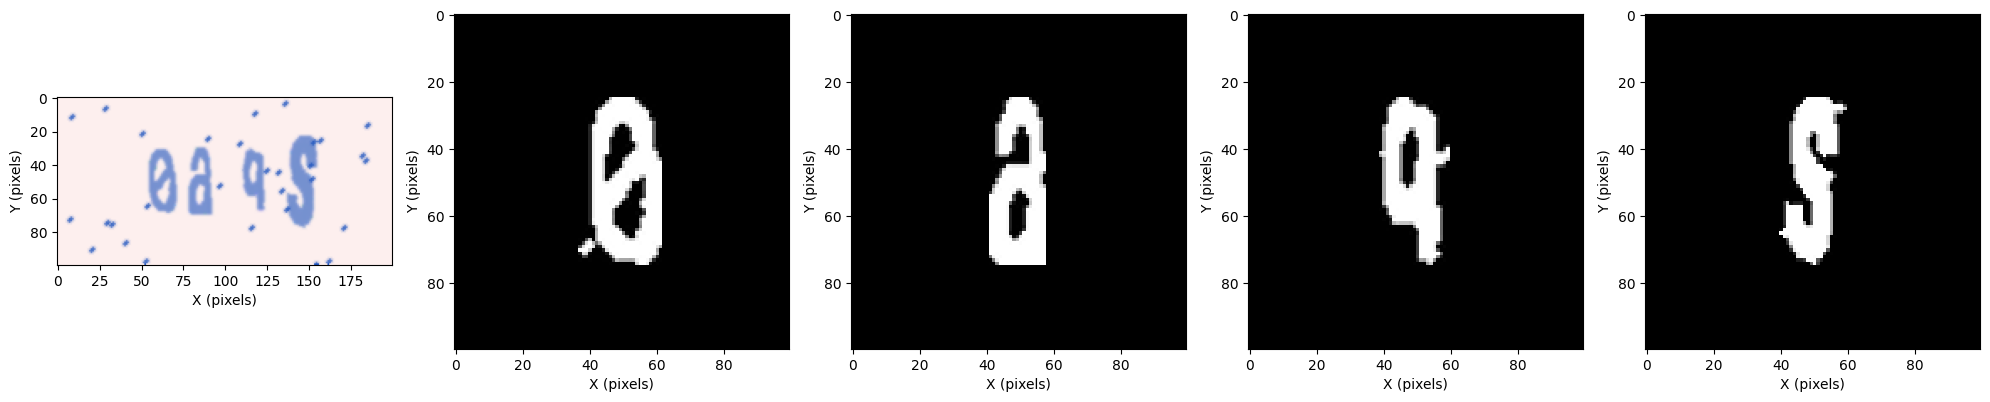

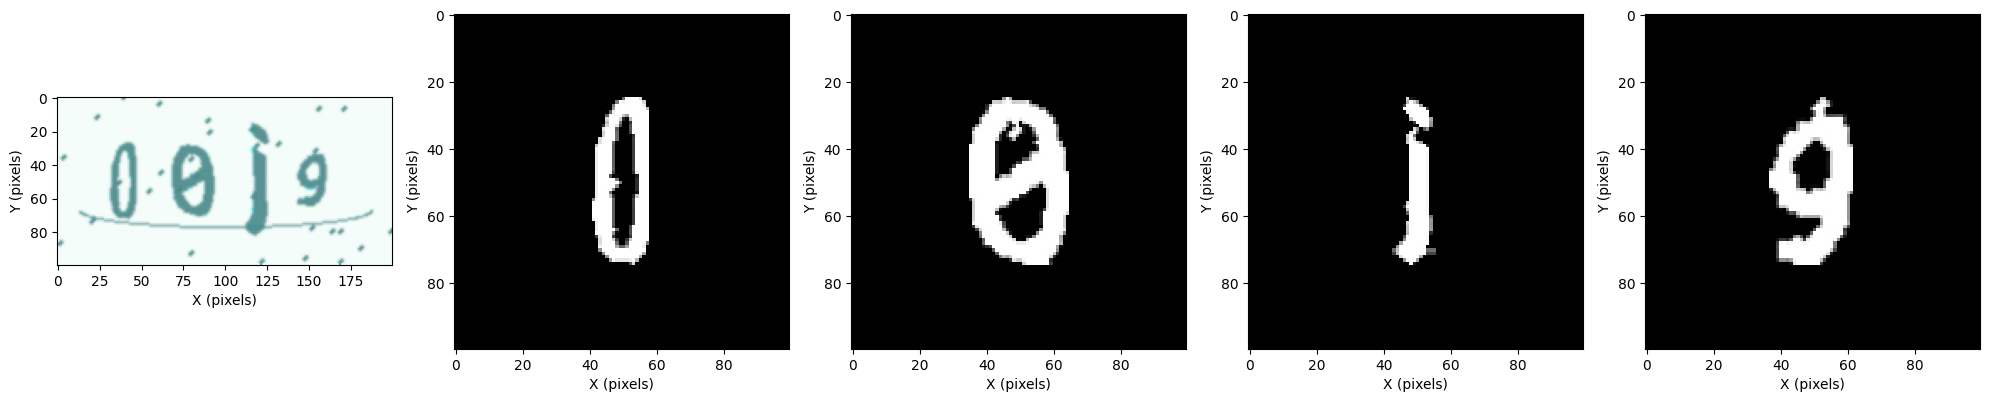

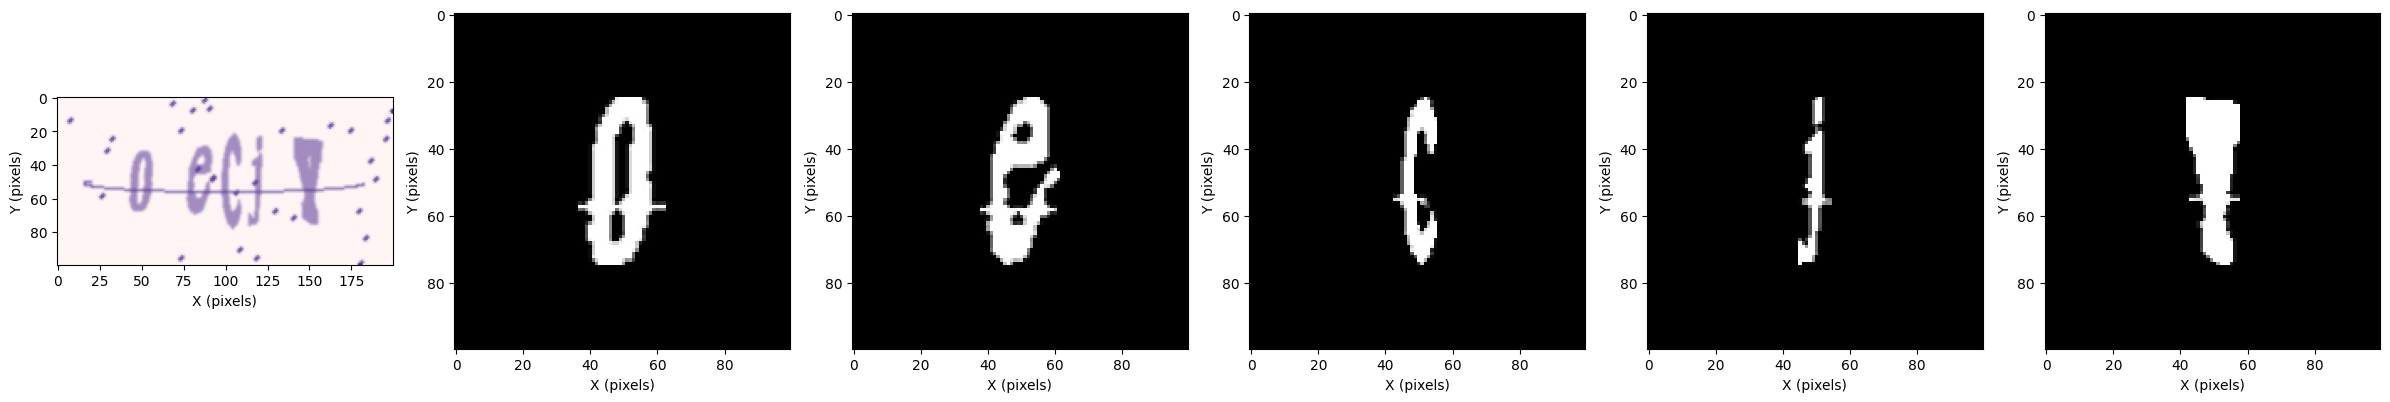

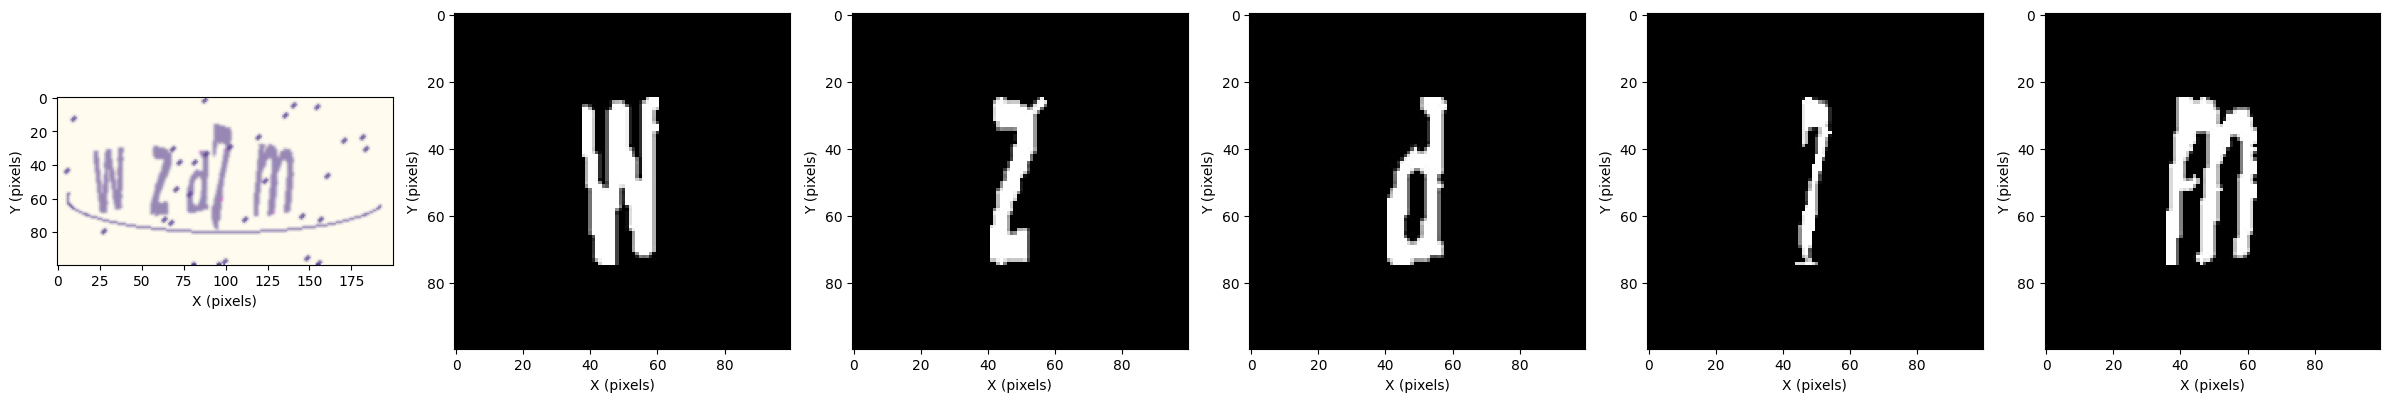

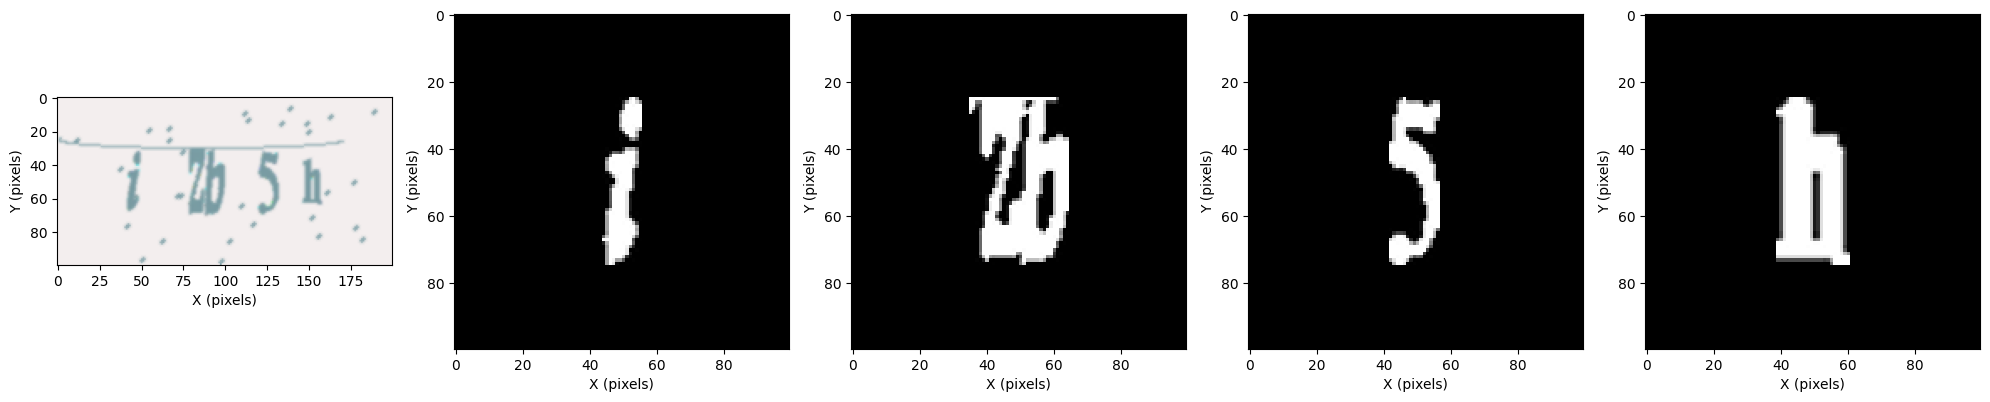

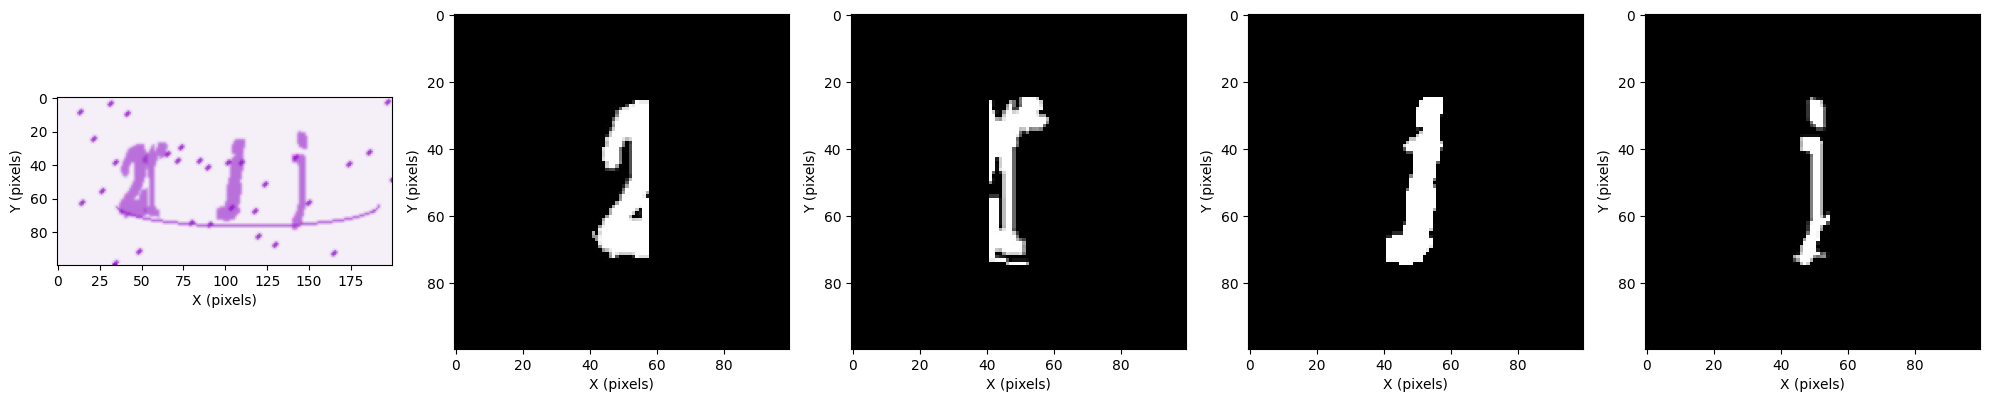

In dataset:  CAPTCHA_dataset/soft/test/
Number of total files:  1432
Number of files where all letters were successfully separated:  1220
Separation success rate:  0.8519553072625698
In dataset:  CAPTCHA_dataset/soft/train/
Number of total files:  6341
Number of files where all letters were successfully separated:  5402
Separation success rate:  0.851916101561268
In dataset:  CAPTCHA_dataset/hard/test/
Number of total files:  1433
Number of files where all letters were successfully separated:  1098
Separation success rate:  0.7662247034193999
In dataset:  CAPTCHA_dataset/hard/train/
Number of total files:  5654
Number of files where all letters were successfully separated:  4382
Separation success rate:  0.7750265298903432
In all datasets:
Number of total files:  14860
Number of files where all letters were successfully separated:  12102
Separation success rate:  0.8144010767160161


In [ ]:
verifyLetterSeparation_someFiles()
verifyLetterSeparation_allFiles([SOFT_TEST_IMAGES_PATH, SOFT_TRAIN_IMAGES_PATH, HARD_TEST_IMAGES_PATH, HARD_TRAIN_IMAGES_PATH])

# **Verify Digit Augmentation**

Here, the data augmentation can be verified in some examples.

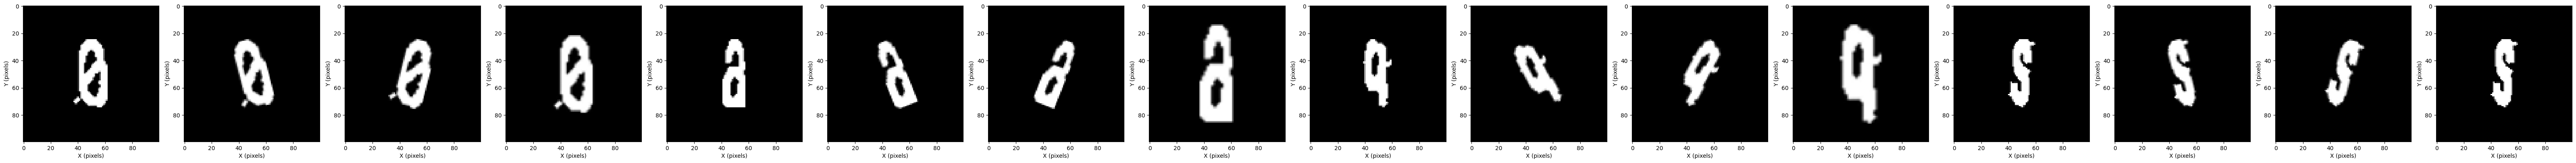

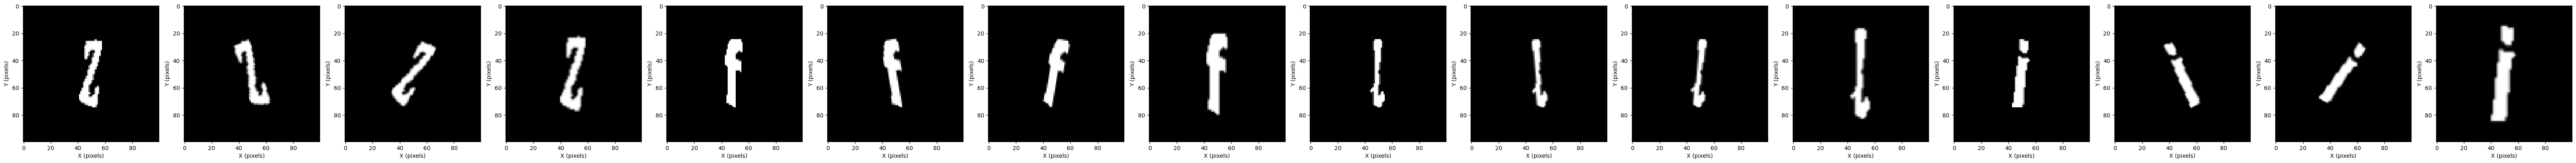

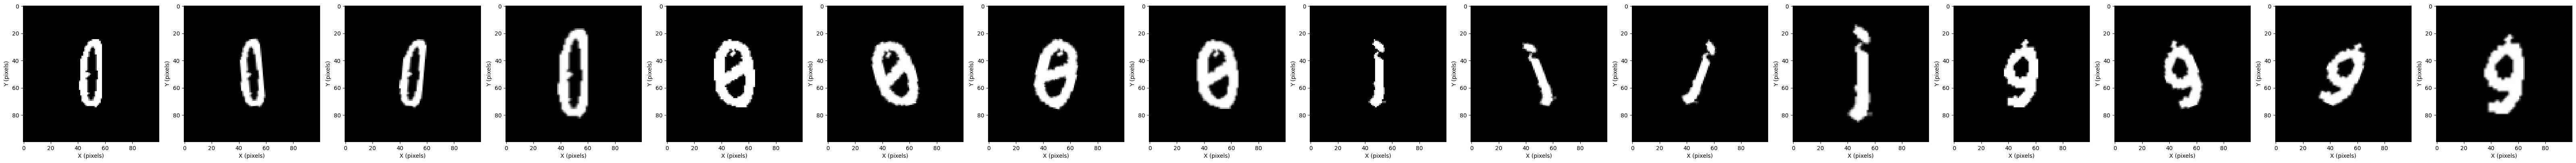

In [ ]:
verify_augmentation_some_files(['CAPTCHA_dataset/soft/train/0aqs.png', 'CAPTCHA_dataset/soft/test/zfli.png', 'CAPTCHA_dataset/hard/train/00j9.png'])

# **Setup**

In [ ]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("The model will be running on", DEVICE, "device")

The model will be running on cuda:0 device


# **Dataset Creation**

The training and testing datasets were by adding the pre-processed separated single digit images of a specific CAPTCHA, only when pre-processing was successful for the entire CAPTCHA. This was done in order to allow to training and test the CNN with only correct data.

In [ ]:
# Train datasets

SOFT_TRAIN_DATASET = create_dataset_from_folder(SOFT_TRAIN_IMAGES_PATH, augment=False, remove_bad_segmentation=True)
soft_train_dataloader = DataLoader(dataset=SOFT_TRAIN_DATASET, batch_size=128, shuffle=True, drop_last=True)

AUGMENTED_SOFT_TRAIN_DATASET = create_dataset_from_folder(SOFT_TRAIN_IMAGES_PATH, augment=True, remove_bad_segmentation=True)
augmented_soft_train_dataloader = DataLoader(dataset=AUGMENTED_SOFT_TRAIN_DATASET, batch_size=128, shuffle=True, drop_last=True)




In [ ]:
# Test datasets
HARD_TEST_DATASET = create_dataset_from_folder(HARD_TEST_IMAGES_PATH, augment= False, remove_bad_segmentation=True)
hard_test_dataloader = DataLoader(dataset=HARD_TEST_DATASET, batch_size=128, shuffle=False)

SOFT_TEST_DATASET = create_dataset_from_folder(SOFT_TEST_IMAGES_PATH, augment=False, remove_bad_segmentation=True)
soft_test_dataloader = DataLoader(dataset=SOFT_TEST_DATASET, batch_size=128, shuffle=False)

# **Visualize Datasets**

In this section, the distribution of digits in the datasets can be seen. Note the increased size of the augmented dataset, where there is less disparity between the amount of letters and numbers.

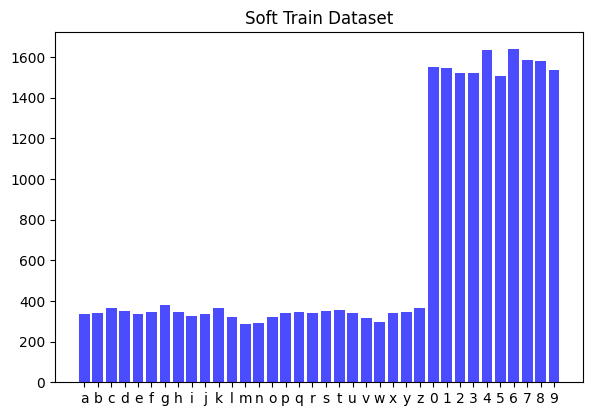

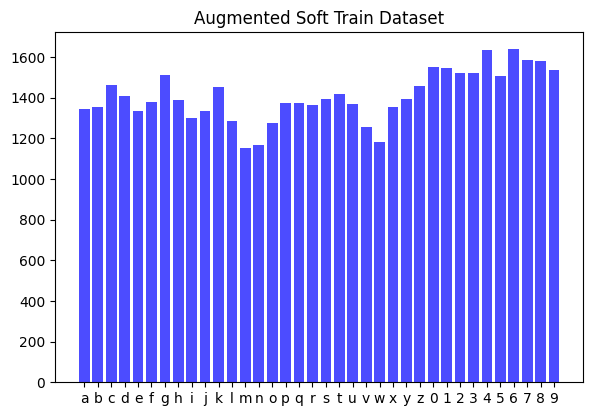

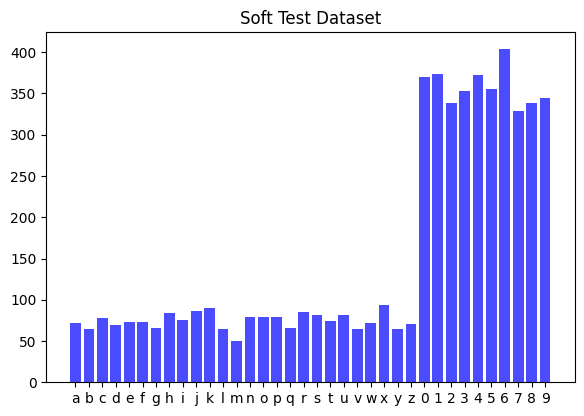

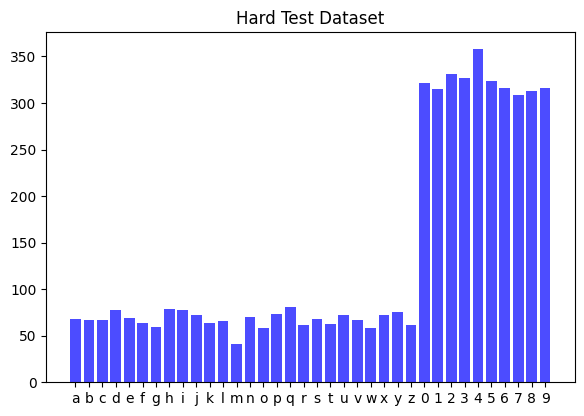

In [ ]:
SOFT_TRAIN_DATASET.visualize("Soft Train Dataset")
AUGMENTED_SOFT_TRAIN_DATASET.visualize("Augmented Soft Train Dataset")
SOFT_TEST_DATASET.visualize("Soft Test Dataset")
HARD_TEST_DATASET.visualize("Hard Test Dataset")

# **Train Soft Models**

In this section, multiple models are trained for the soft dataset: unbalanced, where the soft dataset is used as is, balanced, where class weights are taken into account, and balanced augmented, where the augmented dataset was also used.

When training the models are saved into a folder. Their training performance is plotted.

Best Epoch # 0  Loss= 0.9941927717704522  Accu= 0.7360608552631579
Best Epoch # 1  Loss= 0.21793304873924507  Accu= 0.9333881578947368
Best Epoch # 2  Loss= 0.14825524064271073  Accu= 0.9524259868421052
Best Epoch # 3  Loss= 0.12067448712493244  Accu= 0.9587582236842105
Best Epoch # 4  Loss= 0.09608763743584094  Accu= 0.9671463815789474
Best Epoch # 5  Loss= 0.08329370727909631  Accu= 0.9706414473684211
Best Epoch # 6  Loss= 0.06593742275757616  Accu= 0.9758634868421052
Best Epoch # 7  Loss= 0.058938618960153115  Accu= 0.9784539473684211
Best Epoch # 8  Loss= 0.0487499186376992  Accu= 0.9815789473684211
Best Epoch # 10  Loss= 0.0465686369295183  Accu= 0.9824424342105263
Best Epoch # 12  Loss= 0.04437633673660457  Accu= 0.9834703947368421
Best Epoch # 13  Loss= 0.03700508268574547  Accu= 0.9858963815789473
Best Epoch # 16  Loss= 0.03307434494031201  Accu= 0.9876644736842105
Best Epoch # 17  Loss= 0.02812499545581982  Accu= 0.9885279605263158
Best Epoch # 18  Loss= 0.021502463513752446  

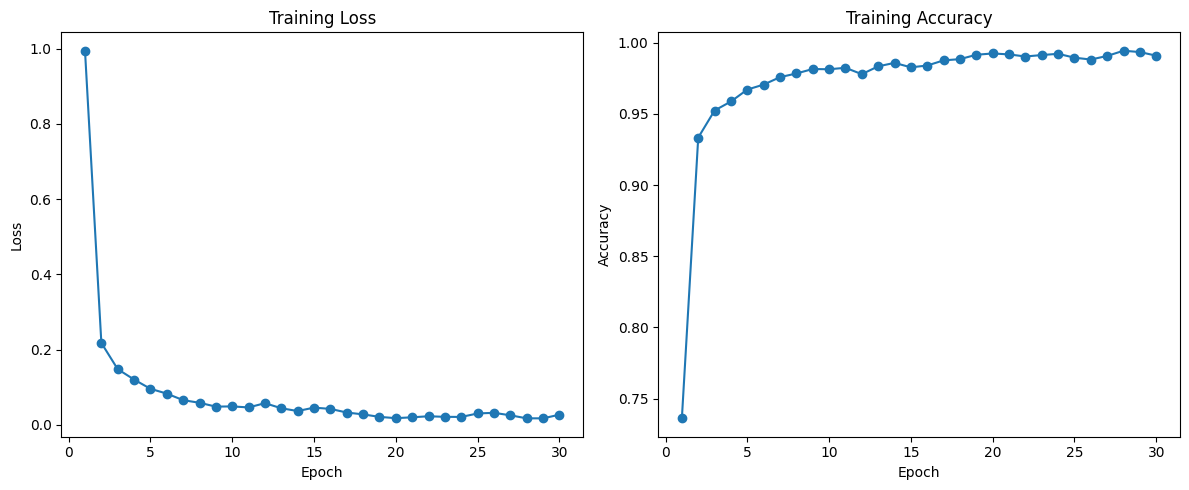

In [ ]:
soft_model_unbalanced = CaptchaCNNModel()
soft_model_unbalanced_train_loss, soft_model_unbalanced_train_accuracy = start_train(model=soft_model_unbalanced, dataloader=soft_train_dataloader,
                                                                                    loss_fn=nn.CrossEntropyLoss().to(DEVICE),
                                                                                    optimizer=SGD(soft_model_unbalanced.parameters(), lr=0.005, momentum=0.9),
                                                                                    device=DEVICE, num_epochs=30,
                                                                                    save_model_folder = "soft_model",
                                                                                    save_model_name = "soft_model_unbalanced",
                                                                                    verbatim=True, save=True)

plot_training_performance(soft_model_unbalanced_train_loss, soft_model_unbalanced_train_accuracy)
#plot_results(soft_model_unbalanced, soft_test_dataloader, DEVICE)

Best Epoch # 0  Loss= 1.400337210454439  Accu= 0.6083881578947369
Best Epoch # 1  Loss= 0.3355090007185936  Accu= 0.8917763157894737
Best Epoch # 2  Loss= 0.2338767496770934  Accu= 0.9194078947368421
Best Epoch # 3  Loss= 0.17562599297808973  Accu= 0.9314967105263158
Best Epoch # 4  Loss= 0.15046734913791482  Accu= 0.9391447368421053
Best Epoch # 5  Loss= 0.11856227457327279  Accu= 0.9483141447368421
Best Epoch # 6  Loss= 0.11387329143717101  Accu= 0.9505345394736842
Best Epoch # 8  Loss= 0.09754840055186498  Accu= 0.9538240131578948
Best Epoch # 9  Loss= 0.0739517600422627  Accu= 0.9625411184210526
Best Epoch # 10  Loss= 0.061209141252268305  Accu= 0.965172697368421
Best Epoch # 11  Loss= 0.049842300866485424  Accu= 0.9722450657894737
Best Epoch # 24  Loss= 0.04646254736979149  Accu= 0.9756990131578948
Best Epoch # 25  Loss= 0.0328580525544423  Accu= 0.9799753289473684
Best Epoch # 26  Loss= 0.02348698018866248  Accu= 0.9855674342105263
Best Epoch # 27  Loss= 0.023374404836297463  Acc

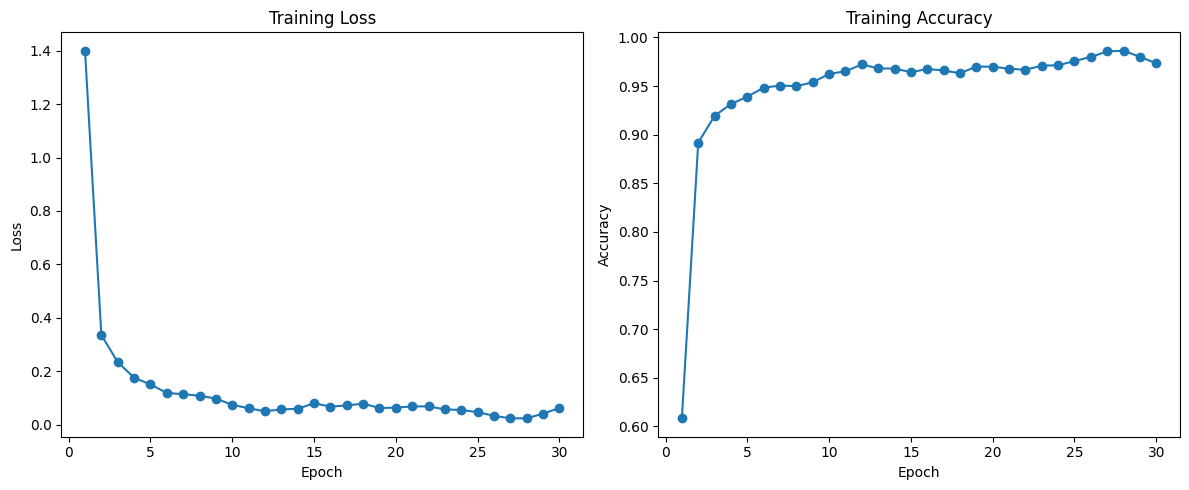

In [ ]:
soft_model_balanced = CaptchaCNNModel()
soft_model_balanced_train_loss, soft_model_balanced_train_accuracy = start_train(model=soft_model_balanced, dataloader=soft_train_dataloader,
                                                                                loss_fn=nn.CrossEntropyLoss(weight=SOFT_TRAIN_DATASET.get_class_weights()).to(DEVICE),
                                                                                optimizer=SGD(soft_model_balanced.parameters(), lr=0.005, momentum=0.9),
                                                                                device=DEVICE, num_epochs=30,
                                                                                save_model_folder = "soft_model",
                                                                                save_model_name = "soft_model_balanced",
                                                                                verbatim=True, save=True)

plot_training_performance(soft_model_balanced_train_loss, soft_model_balanced_train_accuracy)
#plot_results(soft_model_balanced, soft_test_dataloader, DEVICE)

Best Epoch # 0  Loss= 0.9446704535171239  Accu= 0.7297782512626263
Best Epoch # 1  Loss= 0.2601026380340559  Accu= 0.9196851325757576
Best Epoch # 2  Loss= 0.17935941529206254  Accu= 0.943063446969697
Best Epoch # 3  Loss= 0.13630417145487636  Accu= 0.9554924242424242
Best Epoch # 4  Loss= 0.10569017797219332  Accu= 0.9643110795454546
Best Epoch # 5  Loss= 0.09391694172812307  Accu= 0.9680397727272727
Best Epoch # 6  Loss= 0.07980699387303732  Accu= 0.9728535353535354
Best Epoch # 7  Loss= 0.06786828229645964  Accu= 0.9771740845959596
Best Epoch # 8  Loss= 0.0695625315267461  Accu= 0.9772135416666666
Best Epoch # 9  Loss= 0.05952135906813459  Accu= 0.9796598800505051
Best Epoch # 10  Loss= 0.05489621309427112  Accu= 0.981869476010101
Best Epoch # 11  Loss= 0.05048075546933846  Accu= 0.98275726010101
Best Epoch # 12  Loss= 0.04603589453641561  Accu= 0.9840198863636364
Best Epoch # 14  Loss= 0.04464226293776213  Accu= 0.9844933712121212
Best Epoch # 16  Loss= 0.042412831191081704  Accu= 

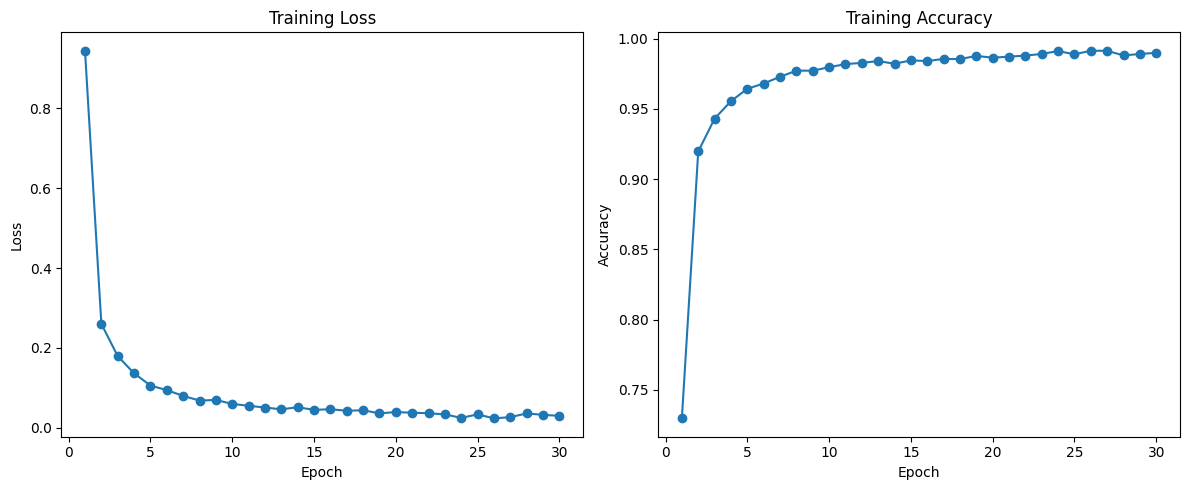

In [ ]:
soft_model_augmented_balanced = CaptchaCNNModel()
soft_model_augmented_balanced_train_loss, soft_model_augmented_balanced_train_accuracy = start_train(model=soft_model_augmented_balanced, dataloader=augmented_soft_train_dataloader,
                                                                                                    loss_fn=nn.CrossEntropyLoss(weight=AUGMENTED_SOFT_TRAIN_DATASET.get_class_weights()).to(DEVICE),
                                                                                                    optimizer=SGD(soft_model_augmented_balanced.parameters(), lr=0.005, momentum=0.9),
                                                                                                    device=DEVICE, num_epochs=30,
                                                                                                    save_model_folder = "soft_model",
                                                                                                    save_model_name = "soft_model_augmented_balanced",
                                                                                                    verbatim=True, save=True)

plot_training_performance(soft_model_augmented_balanced_train_loss, soft_model_augmented_balanced_train_accuracy)
#plot_results(soft_model_augmented_balanced, soft_test_dataloader, DEVICE)

# **Test Soft Models:**

 After training, all of these models are tested with the test soft dataset and the one with the best testing accuracy is selected. Its testing performance is plotted.

Best model:  soft_model/soft_model_augmented_balanced_22-9890.pth  Test accuracy =  0.9676846590909091  Test precision =  0.9653049915249239  Test recall =  0.9669931084512151  Test F1 Score =  0.9656053047985148
Digit Accuracy by Class:


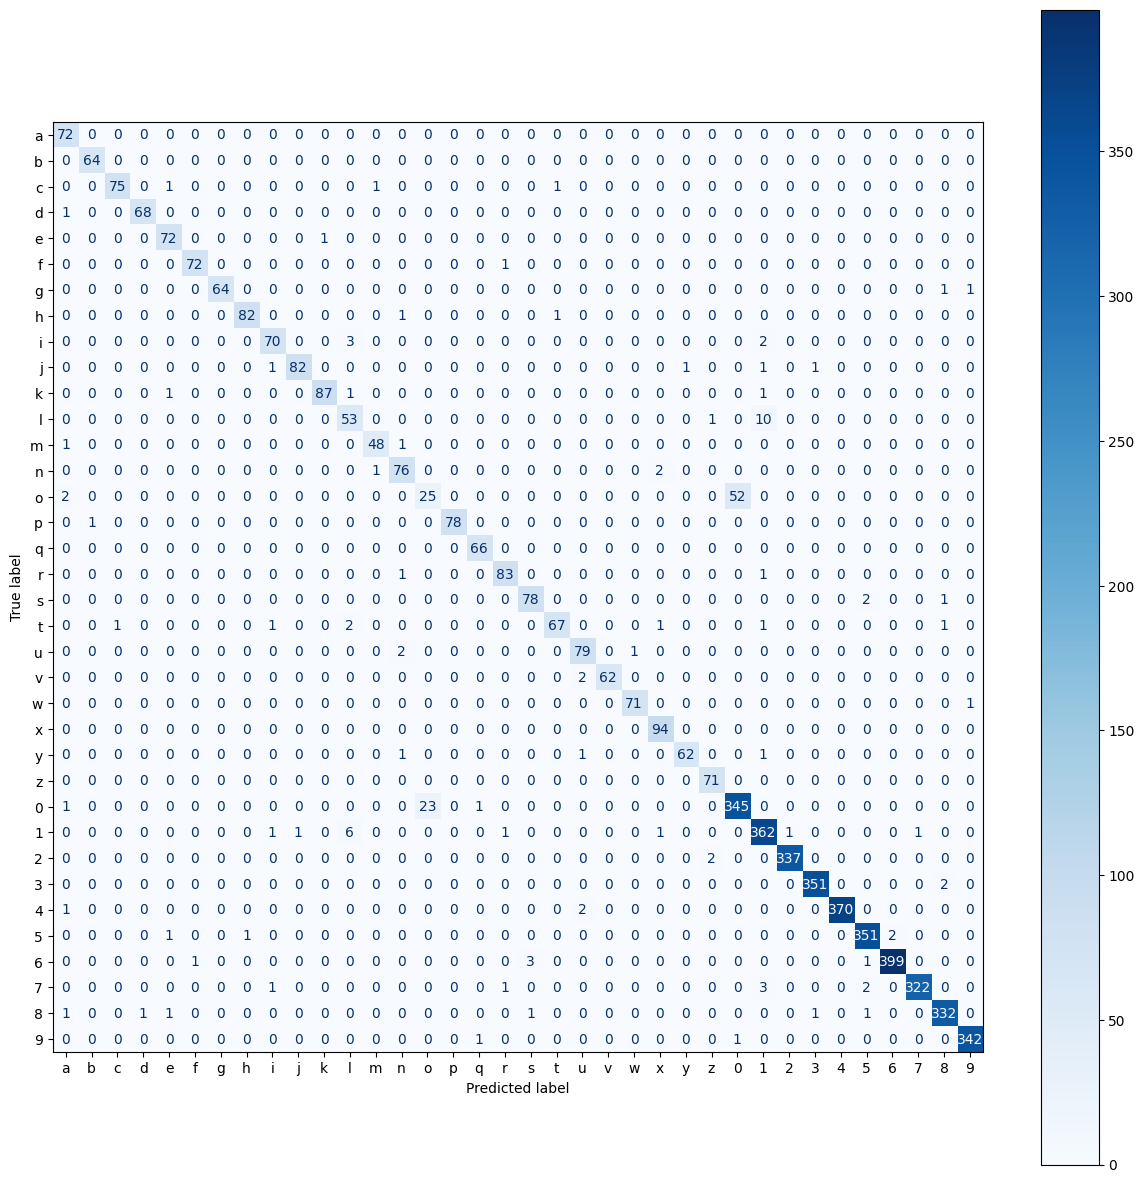

<Figure size 1500x1000 with 0 Axes>

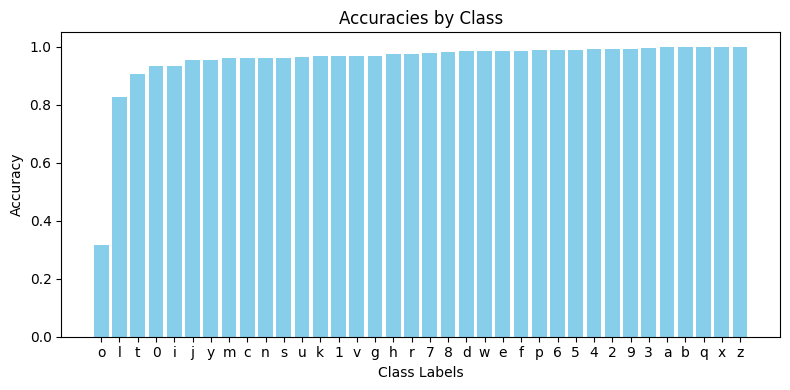

The overall testing accuracy is 0.9669931084512151


In [ ]:
best_soft_model = determine_best_model(models_folder="soft_model", dataloader=soft_test_dataloader,
                                        loss_fn=nn.CrossEntropyLoss().to(DEVICE),
                                        device=DEVICE,
                                        verbatim = True)


plot_results(best_soft_model, soft_test_dataloader, DEVICE)


**Note:** This print is very long, please make sure to see it from the start.

# **Train Hard Model**

Like before, multiple models were trained: unbalanced, balanced augmented balanced. Additionally, the best soft model was retrained using the hard augmented dataset, balanced with class weights.

The hard and augmented hard train datasets are also plotted here.

When training the models are saved into a folder. Their training performance is plotted.

**Note:** Due to RAM limitations, the variables associated with previous cells are deleted here. If you need to run them, please run the Colab from the start again.

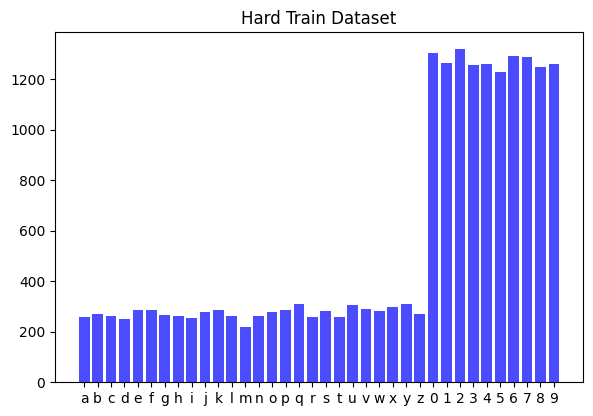

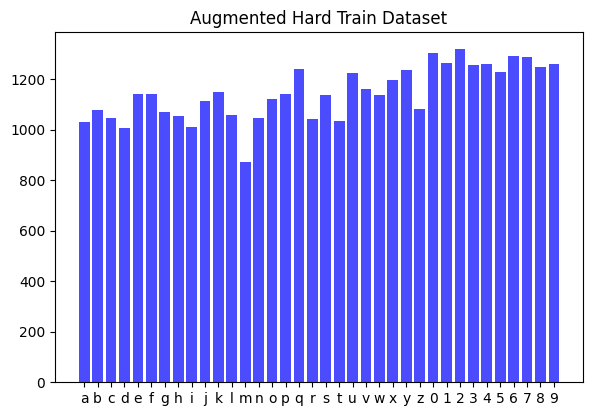

In [ ]:
del SOFT_TRAIN_DATASET
del soft_train_dataloader
del AUGMENTED_SOFT_TRAIN_DATASET
del augmented_soft_train_dataloader

gc.collect()

HARD_TRAIN_DATASET = create_dataset_from_folder(HARD_TRAIN_IMAGES_PATH, augment=False, remove_bad_segmentation=True)
hard_train_dataloader = DataLoader(dataset=HARD_TRAIN_DATASET, batch_size=128, shuffle=True, drop_last=True)

AUGMENTED_HARD_TRAIN_DATASET = create_dataset_from_folder(HARD_TRAIN_IMAGES_PATH, augment=True, remove_bad_segmentation=True)
augmented_hard_train_dataloader = DataLoader(dataset=AUGMENTED_HARD_TRAIN_DATASET, batch_size=128, shuffle=True, drop_last=True)

HARD_TRAIN_DATASET.visualize("Hard Train Dataset")
AUGMENTED_HARD_TRAIN_DATASET.visualize("Augmented Hard Train Dataset")

Best Epoch # 0  Loss= 1.1517783413010259  Accu= 0.686945564516129
Best Epoch # 1  Loss= 0.31993171519810154  Accu= 0.905695564516129
Best Epoch # 2  Loss= 0.21731004844750126  Accu= 0.9328629032258065
Best Epoch # 3  Loss= 0.17202613430638466  Accu= 0.9455141129032258
Best Epoch # 4  Loss= 0.1384240420595292  Accu= 0.9545362903225807
Best Epoch # 5  Loss= 0.10698859766125679  Accu= 0.9641129032258065
Best Epoch # 6  Loss= 0.09487327078898107  Accu= 0.9675907258064517
Best Epoch # 7  Loss= 0.07575816099922503  Accu= 0.9715221774193549
Best Epoch # 8  Loss= 0.07085344775790169  Accu= 0.9740423387096774
Best Epoch # 9  Loss= 0.06461101236542867  Accu= 0.9754536290322581
Best Epoch # 10  Loss= 0.067236666729854  Accu= 0.975554435483871
Best Epoch # 11  Loss= 0.05181425813465349  Accu= 0.9801915322580645
Best Epoch # 16  Loss= 0.046927264594142475  Accu= 0.9820060483870968
Best Epoch # 17  Loss= 0.03613823615915833  Accu= 0.9855846774193548
Best Epoch # 18  Loss= 0.029765765452306837  Accu=

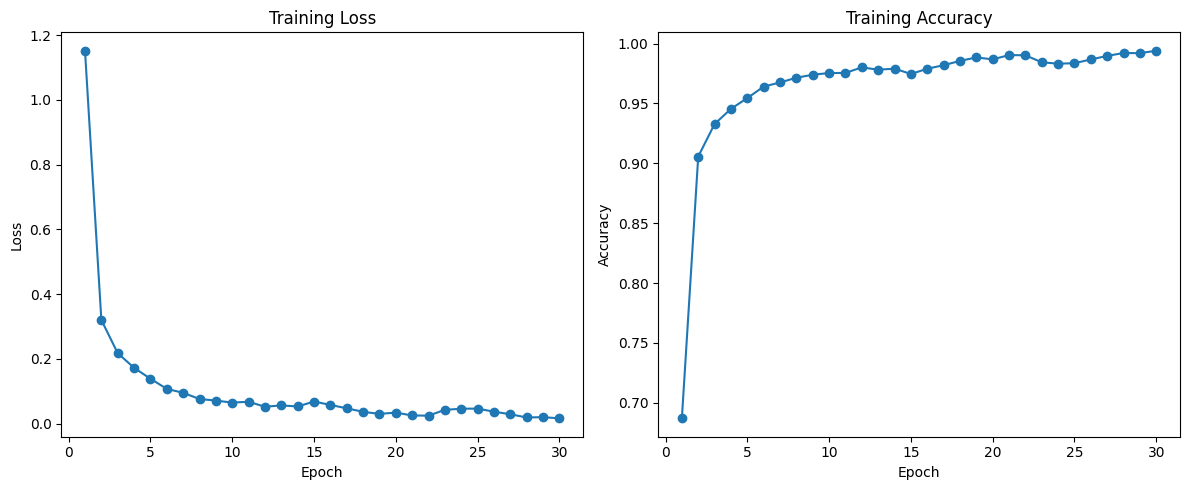

In [ ]:
hard_model_unbalanced = CaptchaCNNModel()
hard_model_unbalanced_train_loss, hard_model_unbalanced_train_accuracy = start_train(model=hard_model_unbalanced, dataloader=hard_train_dataloader,
                                                                                    loss_fn=nn.CrossEntropyLoss().to(DEVICE),
                                                                                    optimizer=SGD(hard_model_unbalanced.parameters(), lr=0.005, momentum=0.9),
                                                                                    device=DEVICE, num_epochs=30,
                                                                                    save_model_folder = "hard_model",
                                                                                    save_model_name = "hard_model_unbalanced",
                                                                                    verbatim=True, save=True)

plot_training_performance(hard_model_unbalanced_train_loss, hard_model_unbalanced_train_accuracy)

Best Epoch # 0  Loss= 1.6511588908010912  Accu= 0.55
Best Epoch # 1  Loss= 0.4577911534617024  Accu= 0.8637600806451613
Best Epoch # 2  Loss= 0.30463089471863164  Accu= 0.9006552419354839
Best Epoch # 3  Loss= 0.257732723749453  Accu= 0.9141129032258064
Best Epoch # 4  Loss= 0.18970250780543974  Accu= 0.9298387096774193
Best Epoch # 5  Loss= 0.16615249228573614  Accu= 0.9356854838709677
Best Epoch # 6  Loss= 0.12273457163283902  Accu= 0.9452620967741936
Best Epoch # 7  Loss= 0.11691391002987661  Accu= 0.9455645161290323
Best Epoch # 8  Loss= 0.10737575206064409  Accu= 0.9497479838709677
Best Epoch # 9  Loss= 0.11076456700121202  Accu= 0.95
Best Epoch # 10  Loss= 0.08809957209854356  Accu= 0.9531754032258064
Best Epoch # 11  Loss= 0.06261706199016302  Accu= 0.9621975806451613
Best Epoch # 12  Loss= 0.05928664074069069  Accu= 0.9644153225806451
Best Epoch # 15  Loss= 0.057180480923383466  Accu= 0.9674395161290322
Best Epoch # 16  Loss= 0.05308730763593508  Accu= 0.9677923387096774
Best E

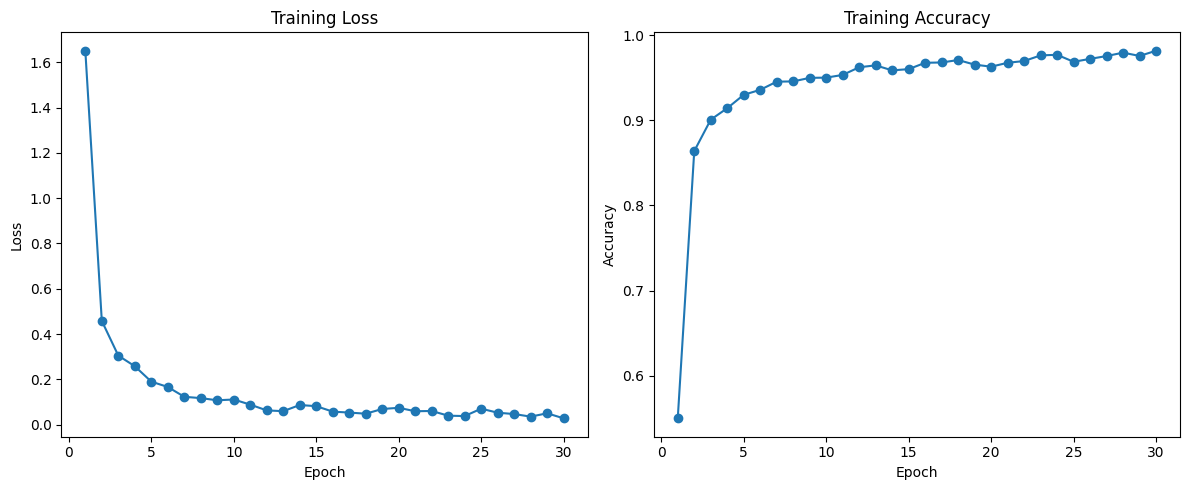

In [ ]:
hard_model_balanced = CaptchaCNNModel()
hard_model_balanced_train_loss, hard_model_balanced_train_accuracy = start_train(model=hard_model_balanced, dataloader=hard_train_dataloader,
                                                                                loss_fn=nn.CrossEntropyLoss(weight=HARD_TRAIN_DATASET.get_class_weights()).to(DEVICE),
                                                                                optimizer=SGD(hard_model_balanced.parameters(), lr=0.005, momentum=0.9),
                                                                                device=DEVICE, num_epochs=30,
                                                                                save_model_folder = "hard_model",
                                                                                save_model_name = "hard_model_balanced",
                                                                                verbatim=True, save=True)

plot_training_performance(hard_model_balanced_train_loss, hard_model_balanced_train_accuracy)

Best Epoch # 0  Loss= 1.1346171556607536  Accu= 0.6806094720496895
Best Epoch # 1  Loss= 0.3487705275971697  Accu= 0.8969332298136646
Best Epoch # 2  Loss= 0.24411604872771672  Accu= 0.926266498447205
Best Epoch # 3  Loss= 0.1815816626438628  Accu= 0.9445603649068323
Best Epoch # 4  Loss= 0.14588597500176162  Accu= 0.9521787655279503
Best Epoch # 5  Loss= 0.11997507465714068  Accu= 0.9610588121118012
Best Epoch # 6  Loss= 0.10777473091639532  Accu= 0.9647952251552795
Best Epoch # 7  Loss= 0.0931127852794963  Accu= 0.968361801242236
Best Epoch # 8  Loss= 0.08995145972042998  Accu= 0.9701814829192547
Best Epoch # 9  Loss= 0.08535617944836524  Accu= 0.9713460791925466
Best Epoch # 10  Loss= 0.06905040763006169  Accu= 0.9761257763975155
Best Epoch # 11  Loss= 0.06649299319804594  Accu= 0.9765625
Best Epoch # 12  Loss= 0.058192117848312075  Accu= 0.9796195652173914
Best Epoch # 14  Loss= 0.05320879887219704  Accu= 0.9816090838509317
Best Epoch # 15  Loss= 0.04838328799399148  Accu= 0.983113

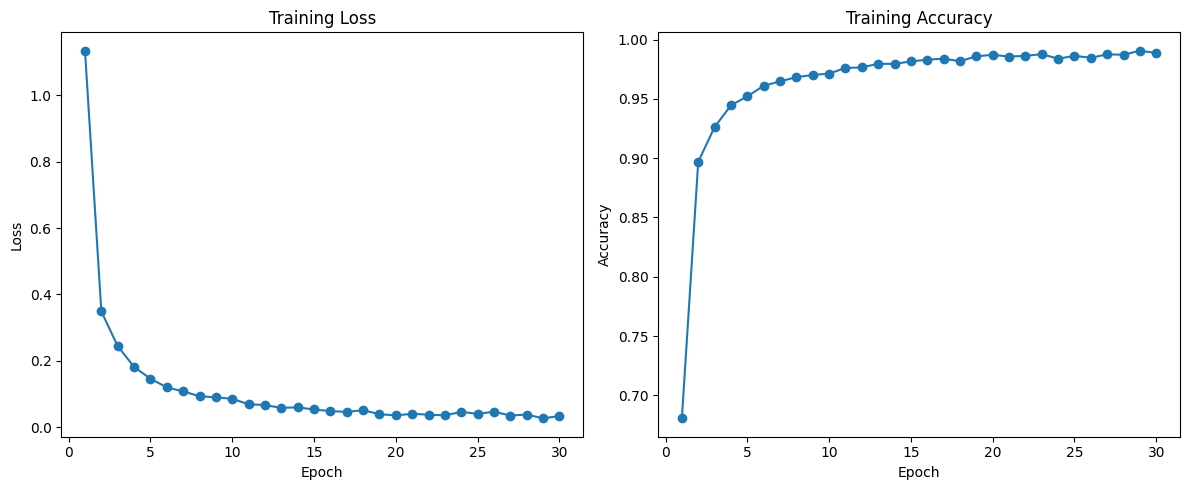

In [ ]:
hard_model_augmented_balanced = CaptchaCNNModel()
hard_model_augmented_balanced_train_loss, hard_model_augmented_balanced_train_accuracy = start_train(model=hard_model_augmented_balanced, dataloader=augmented_hard_train_dataloader,
                                                                                                    loss_fn=nn.CrossEntropyLoss(weight=AUGMENTED_HARD_TRAIN_DATASET.get_class_weights()).to(DEVICE),
                                                                                                    optimizer=SGD(hard_model_augmented_balanced.parameters(), lr=0.005, momentum=0.9),
                                                                                                    device=DEVICE, num_epochs=30,
                                                                                                    save_model_folder = "hard_model",
                                                                                                    save_model_name = "hard_model_augmented_balanced",
                                                                                                    verbatim=True, save=True)

plot_training_performance(hard_model_augmented_balanced_train_loss, hard_model_augmented_balanced_train_accuracy)

Best Epoch # 0  Loss= 0.22516840967054694  Accu= 0.941309200310559
Best Epoch # 1  Loss= 0.1257397868433354  Accu= 0.9639460403726708
Best Epoch # 2  Loss= 0.08515533408069093  Accu= 0.9728746118012422
Best Epoch # 3  Loss= 0.07164665026104321  Accu= 0.975980201863354
Best Epoch # 4  Loss= 0.061940171538927356  Accu= 0.9789402173913043
Best Epoch # 5  Loss= 0.050414011556646494  Accu= 0.9829435170807453
Best Epoch # 8  Loss= 0.038328926764090214  Accu= 0.9861461568322981
Best Epoch # 12  Loss= 0.03349731900144993  Accu= 0.987893051242236
Best Epoch # 14  Loss= 0.02832568995636506  Accu= 0.9900038819875776
Best Epoch # 15  Loss= 0.027423852812954345  Accu= 0.9905861801242236
Best Epoch # 21  Loss= 0.02243173499309649  Accu= 0.9923573369565217
Best Epoch # 23  Loss= 0.020494346500521524  Accu= 0.9931094720496895


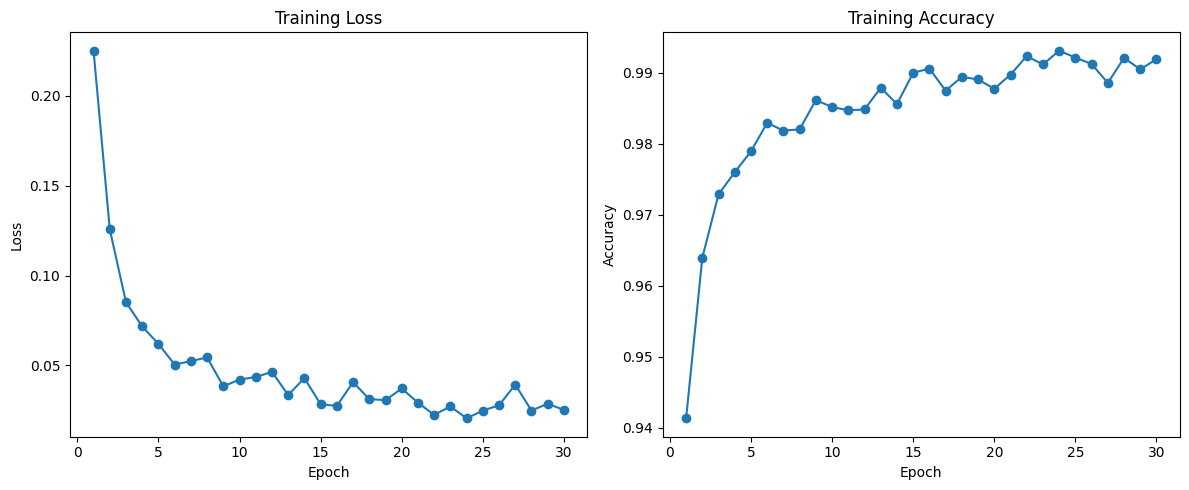

In [ ]:
hard_soft_model_augmented_balanced = best_soft_model

hard_soft_model_augmented_balanced_train_loss, hard_soft_model_augmented_balanced_train_accuracy = start_train(model=hard_soft_model_augmented_balanced, dataloader=augmented_hard_train_dataloader,
                                                                                                            loss_fn=nn.CrossEntropyLoss(weight=AUGMENTED_HARD_TRAIN_DATASET.get_class_weights()).to(DEVICE),
                                                                                                            optimizer=SGD(hard_soft_model_augmented_balanced.parameters(), lr=0.005, momentum=0.9),
                                                                                                            device=DEVICE, num_epochs=30,
                                                                                                            save_model_folder = "hard_model",
                                                                                                            save_model_name = "hard_soft_model_augmented_balanced",
                                                                                                            verbatim=True, save=True)

plot_training_performance(hard_soft_model_augmented_balanced_train_loss, hard_soft_model_augmented_balanced_train_accuracy)

# **Test Hard Model**

 Again, after training all of the models are tested with the test hard dataset and the one with the best testing accuracy is selected. Its testing performance is plotted.

Best model:  hard_model/hard_soft_model_augmented_balanced_8-9861.pth  Test accuracy =  0.9598793967784351  Test precision =  0.9594561743067547  Test recall =  0.9598474201967476  Test F1 Score =  0.95905059014863
Digit Accuracy by Class:


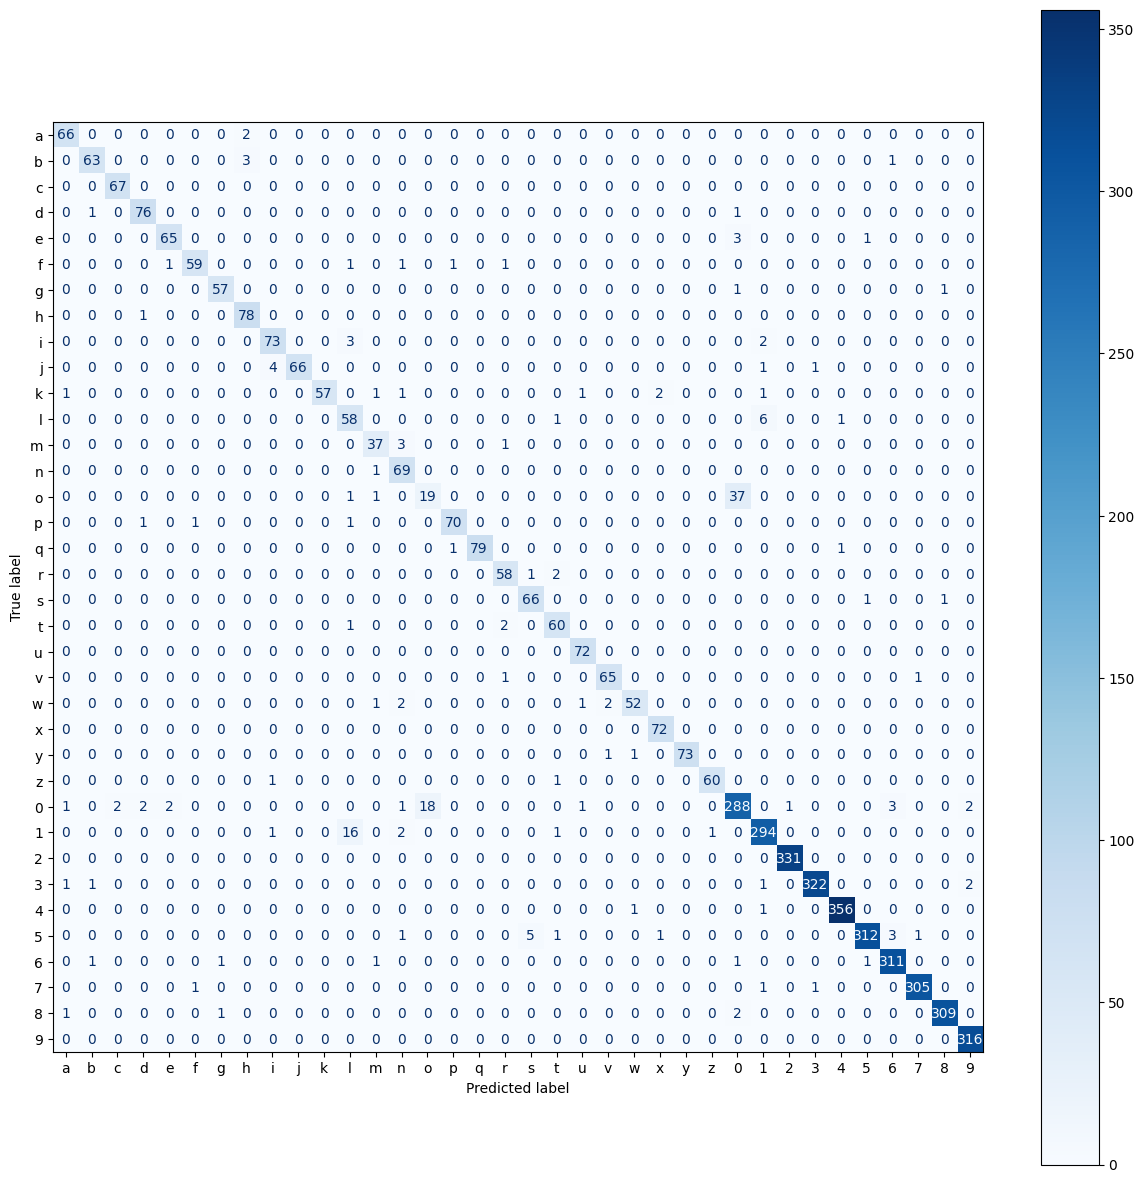

<Figure size 1500x1000 with 0 Axes>

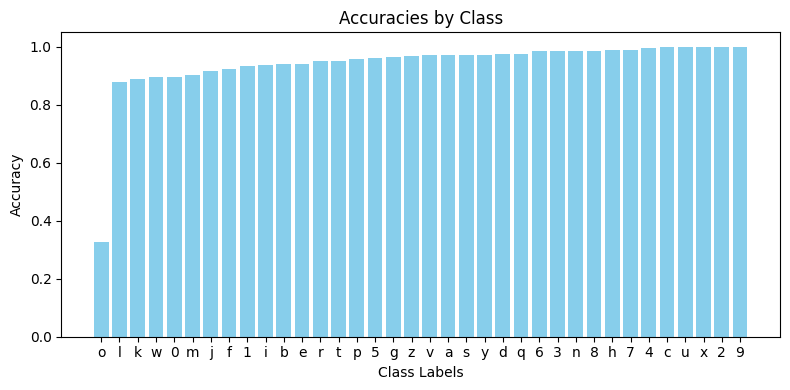

The overall testing accuracy is 0.9598474201967476


In [ ]:
best_hard_model = determine_best_model(models_folder="hard_model", dataloader=hard_test_dataloader,
                                        loss_fn=nn.CrossEntropyLoss().to(DEVICE),
                                        device=DEVICE,
                                        verbatim = True)


plot_results(best_hard_model, hard_test_dataloader, DEVICE)

**Note:** This print is very long, please make sure to see it from the start.

# **Result Analysis**

For both the models trained on soft and hard datasets, as revealed by the tests, the models perform very well, obtaining a testing accuracy of over 95% for both soft and hard datasets. The precision, recall and F1-score are also very high, around 95% for all of them, indicating that the models were resilient against false positives and false negatives. Consequently, it can be concluded that the models were not overfitted.

The best soft model is the one which was trained in the non-augmented data and without balancing.

The best hard model corresponds to the best soft model, trained again using the hard augmented dataset with class weight balancing. This also meant the model started with a higher training accuracy when compared to the other hard models that were trained from scratch. Notably, the augmentation in the dataset, in general, does not significantly impact the test outcomes. This is reflected in the fact that the best model trained on the soft dataset was trained without augmentation, while the best model trained on the hard dataset incorporates augmentation.

Perhaps as expected, the models mainly struggle to distinguish similar numbers and letters, '0' with 'o' and '1' with 'l'. For all other cases, accuracy is very high.

# **Comparision to other work**

In the work "Deep-CAPTCHA: a deep learning based CAPTCHA solver for vulnerability assessment", preprocessing begins by resizing the original image from 135 x 50 pixels to 67 x 25 pixels. To optimize tasks for text-based CAPTCHA systems, the image is converted from a three-channel RGB to a grayscale format, reducing redundant data. Noise reduction is achieved through the application of a Median Filter algorithm.

The referenced study employs Recurrent Neural Networks (RNNs) for CAPTCHA decoding, integrating Convolutional layers, Max-Pooling layers, dense layers, and Softmax layers. Binary cross-entropy serves as the loss function, comparing binary matrices. The Adam optimizer is chosen for training efficiency, demonstrating comparable results to Stochastic Gradient Descent (SGD) with faster convergence. In contrast, our approach utilizes Convolutional Neural Networks (CNN). Both approaches involve Convolutional layers and Max-Pooling layers for feature extraction. Binary cross-entropy is employed as the loss function in both models, and the Adam optimizer is chosen for training efficiency, showcasing comparable results to SGD with faster convergence.

Performance analysis of the referenced study reveals an overall accuracy of 99.33% on the training set and 98.94% on the test set, computed based on correctly detecting entire CAPTCHAs. For individual digits, accuracy ranges from 99.72% to 99.91%, which is significantly higher than our work. It's important to note that the referenced study is an extensive academic research project comparing to our project.

Reference: Noury, Z., & Rezaei, M. (2020). Deep-CAPTCHA: a deep learning based CAPTCHA solver for vulnerability assessment. arXiv preprint arXiv:2006.08296

# **Full CAPTCHA Solver**

Finally, the whole CAPTCHA solving pipeline was implemented to predict all the digits in a CAPTCHA image. The CAPTCHA image is pre-processed into the separated digits and then each is inputted to the best model to predict the CAPTCHA.

The pipeline is successful when all of these steps work as intended, such that the predicted CAPTCHA matches the solution.

The success rates of the soft and hard models are printed and some examples of the predicted CAPTCHA are plotted. This is done using both the train and and test datasets, in order to understand the effect of the pre-processing in the whole data.

In [ ]:
def captcha_solver(model, single_captcha_y_true, separated_letters):

    captcha_prediction = []

    captcha_dataset = DigitCaptchaDataset(single_captcha_y_true, separated_letters)


    captcha_dataloader = DataLoader(dataset=captcha_dataset, batch_size=len(separated_letters), shuffle=False, drop_last=False)

    images, labels, probs = get_predictions(model, captcha_dataloader, DEVICE)
    pred_labels = torch.argmax(probs, 1)

    for pred_label in pred_labels:
        captcha_prediction.append(classification_to_digit(pred_label))


    return ''.join(captcha_prediction)


def verify_captcha_solver(model, datasetPaths):
    numFiles = 0
    numFilesCaptchaSuccess = 0

    for datasetPath in datasetPaths:
        # Get all the filepaths that end with .png
        filePaths = [os.path.join(datasetPath, file) for file in os.listdir(datasetPath) if file.lower().endswith('.png')]

        numFilesInDataset = 0
        numFilesCaptchaSuccessInDataset = 0

        for filePath in filePaths:

            single_captcha_y_true = generate_y_true_from_filename(filePath)

            numFiles += 1
            numFilesInDataset += 1

            image = cv2.imread(filePath)
            seperatedLetters = letterSeparation(image, plot=False)

            trueCaptchaString = os.path.basename(filePath).split('.')[0]

            if(len(trueCaptchaString) == len(seperatedLetters)):
                if(trueCaptchaString == captcha_solver(model, single_captcha_y_true, seperatedLetters)):
                    numFilesCaptchaSuccess += 1
                    numFilesCaptchaSuccessInDataset += 1

        print("In dataset: ", datasetPath)
        print("Number of total files: ", numFilesInDataset)
        print("Number of files where the captcha was successfully solved: ", numFilesCaptchaSuccessInDataset)
        print("Captcha solver success rate: ", numFilesCaptchaSuccessInDataset/numFilesInDataset, '\n')


    print("In all datasets:")
    print("Number of total files: ", numFiles)
    print("Number of files where the captcha was successfully solved: ", numFilesCaptchaSuccess)
    print("Captcha solver success rate: ", numFilesCaptchaSuccess/numFiles)


def verify_captcha_solver_some_files(model, filePaths):

    for filePath in filePaths:

        single_captcha_y_true = generate_y_true_from_filename(filePath)

        image = cv2.imread(filePath)
        seperatedLetters = letterSeparation(image, plot=False)

        trueCaptchaString = os.path.basename(filePath).split('.')[0]
        print("Captcha solver: ", captcha_solver(model, single_captcha_y_true, seperatedLetters))
        title = "True captcha: " + trueCaptchaString + " Predicted captcha: " + captcha_solver(model, single_captcha_y_true, seperatedLetters)
        plotMultipleImages([image], titles=[title], plot=True)

In [ ]:
verify_captcha_solver(best_soft_model, [SOFT_TRAIN_IMAGES_PATH, SOFT_TEST_IMAGES_PATH])
verify_captcha_solver(best_hard_model, [HARD_TRAIN_IMAGES_PATH, HARD_TEST_IMAGES_PATH])


In dataset:  CAPTCHA_dataset/soft/train/
Number of total files:  6341
Number of files where the captcha was successfully solved:  4709
Captcha solver success rate:  0.7426273458445041 

In dataset:  CAPTCHA_dataset/soft/test/
Number of total files:  1432
Number of files where the captcha was successfully solved:  1005
Captcha solver success rate:  0.7018156424581006 

In all datasets:
Number of total files:  7773
Number of files where the captcha was successfully solved:  5714
Captcha solver success rate:  0.7351087096359192
In dataset:  CAPTCHA_dataset/hard/train/
Number of total files:  5654
Number of files where the captcha was successfully solved:  4087
Captcha solver success rate:  0.7228510788822072 

In dataset:  CAPTCHA_dataset/hard/test/
Number of total files:  1433
Number of files where the captcha was successfully solved:  921
Captcha solver success rate:  0.6427076064200977 

In all datasets:
Number of total files:  7087
Number of files where the captcha was successfully so

Captcha solver:  0aqs


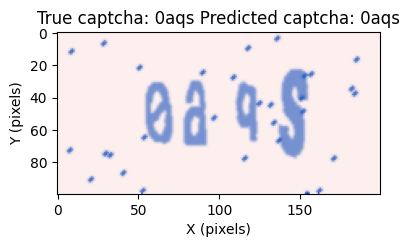

Captcha solver:  00j9


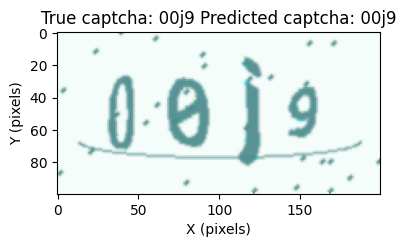

Captcha solver:  0ecjy


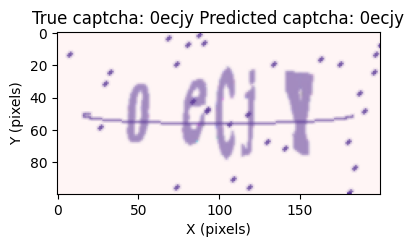

Captcha solver:  wzd7m


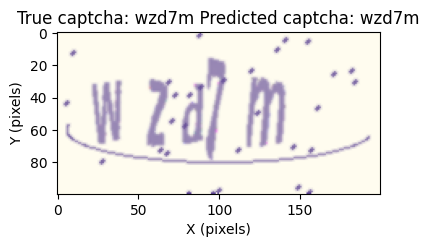

In [ ]:
verify_captcha_solver_some_files(best_hard_model, ['CAPTCHA_dataset/soft/train/0aqs.png', 'CAPTCHA_dataset/hard/train/00j9.png', 'CAPTCHA_dataset/hard/train/0ecjy.png', 'CAPTCHA_dataset/hard/train/wzd7m.png'])

# **Conclusion**

While the models demonstrate commendable performance, it's crucial to note that the bottleneck in the pipeline lies in the preprocessing step, particularly in distinguishing connected digits. Consequently, the overall success rate of solving the entire CAPTCHA is lower, approximately 70%.

However, this success rate primarily reflects the compounded probabilistic effect of solving a problem where the entire pipeline needs to run flawlessly multiple times per CAPTCHA.

In conclusion, the project was successfully completed, employing a combination of traditional computer vision, namely filtering and contour extraction, and machine learning techniques, namely data augmentation and the development of a CNN, to address the proposed problem.

